## Постановка задачи
Загрузите данные, приведите их к числовым, заполните пропуски, нормализуйте данные и оптимизируйте память.

Сформируйте параллельный ансамбль (стекинг) из CatBoost, градиентного бустинга, XGBoost и LightGBM. Используйте лучшие гиперпараметры, подобранные ранее, или найдите их через перекрестную проверку. Итоговое решение рассчитайте на основании самого точного предсказания класса у определенной модели ансамбля: выберите для каждого класса модель, которая предсказывает его лучше всего.

Проведите расчеты и выгрузите результат в виде submission.csv

Данные:
* https://video.ittensive.com/machine-learning/prudential/train.csv.gz
* https://video.ittensive.com/machine-learning/prudential/test.csv.gz
* https://video.ittensive.com/machine-learning/prudential/sample_submission.csv.gz

Соревнование: https://www.kaggle.com/c/prudential-life-insurance-assessment/

© ITtensive, 2020

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Загрузка данных

In [2]:
data = pd.read_csv("https://video.ittensive.com/machine-learning/prudential/train.csv.gz")
print (data.info()) #Посмотрим сводную информацию методом info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)
memory usage: 58.0+ MB
None


In [3]:
print(data) # прочитаем файл данных, в столбце «Product_Info_2» тип данных смешенный (буква-цифра)

          Id  Product_Info_1 Product_Info_2  Product_Info_3  Product_Info_4  \
0          2               1             D3              10        0.076923   
1          5               1             A1              26        0.076923   
2          6               1             E1              26        0.076923   
3          7               1             D4              10        0.487179   
4          8               1             D2              26        0.230769   
...      ...             ...            ...             ...             ...   
59376  79142               1             D1              10        0.230769   
59377  79143               1             D3              26        0.230769   
59378  79144               1             E1              26        0.076923   
59379  79145               1             D2              10        0.230769   
59380  79146               1             A8              26        0.076923   

       Product_Info_5  Product_Info_6  Product_Info

### Предобработка данных

In [4]:
# Проведем нормализацию данных через предварительную обработку – вызовем функцию  preprocess по параметру «df»
def data_preprocess (df):
#Для предварительной обработки данных переведем смешенное значение параметров 
#"Product_Info_2" отдельно в числовое и буквенное значение     
    df["Product_Info_2_1"] = df["Product_Info_2"].str.slice(0, 1)
    df["Product_Info_2_2"] = pd.to_numeric(df["Product_Info_2"].str.slice(1, 2))
# с помощью функции «to_numeric» преобразуем аргумент в числовой тип
# удалим из набора параметров исходную серию данных, чтобы ее не учитывать в модели.   
    df.drop(labels=["Product_Info_2"], axis=1, inplace=True)
# в массиве данных «Product_Info_2_1» используя метод «unique()» используя уникальные элементы данных
    for l in df["Product_Info_2_1"].unique():
#с помощью функции astype() данные преобразуем  в целочисленный массив «"int8"»
        df["Product_Info_2_1" + l] = df["Product_Info_2_1"].isin([l]).astype("int8")
# удалим из набора параметров  данные «Product_Info_2_1», чтобы ее не учитывать в модели.      
    df.drop(labels=["Product_Info_2_1"], axis=1, inplace=True)
# заменим нулевые значения на «-1»
    df.fillna(value=-1, inplace=True)
    data["Response"] = data["Response"] - 1
    return df # возвращаем значение "df" 

In [5]:
# проведем предварительную обработку данных
data = data_preprocess(data)

### Набор столбцов для расчета

In [6]:
# Выделим набор столбцов для расчета
# проведем группировку данных по столбцам «Страховая история», 
# «Застрахованная информация», «Медицинское ключевое слово», 
# «Семейная история», «История болезни», «Информация о продукте» 
columns_groups = ["Insurance_History", "InsurеdInfo", "Medical_Keyword",
                  "Family_Hist", "Medical_History", "Product_Info"]
# используем данные: рост (Ht), вес (Wt), возраст (Ins_Age), индекс массы тела (BMI),
columns = ["Wt", "Ht", "Ins_Age", "BMI"]
# группируем данные, первый массив данных «columns» добавляет в конец второго массива
for cg in columns_groups:
    columns.extend(data.columns[data.columns.str.startswith(cg)])
print (columns)

['Wt', 'Ht', 'Ins_Age', 'BMI', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_5', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Medical_Keyword_1', 'Medical_Keyword_2', 'Medical_Keyword_3', 'Medical_Keyword_4', 'Medical_Keyword_5', 'Medical_Keyword_6', 'Medical_Keyword_7', 'Medical_Keyword_8', 'Medical_Keyword_9', 'Medical_Keyword_10', 'Medical_Keyword_11', 'Medical_Keyword_12', 'Medical_Keyword_13', 'Medical_Keyword_14', 'Medical_Keyword_15', 'Medical_Keyword_16', 'Medical_Keyword_17', 'Medical_Keyword_18', 'Medical_Keyword_19', 'Medical_Keyword_20', 'Medical_Keyword_21', 'Medical_Keyword_22', 'Medical_Keyword_23', 'Medical_Keyword_24', 'Medical_Keyword_25', 'Medical_Keyword_26', 'Medical_Keyword_27', 'Medical_Keyword_28', 'Medical_Keyword_29', 'Medical_Keyword_30', 'Medical_Keyword_31', 'Medical_Keyword_32', 'Medical_Keyword_33', 'Medical_Keyword_34', 'Medical_Keyword_35', 'Medical_Keyword_36', 'M

### Нормализация данных

In [7]:
#Алгоритмы машинного обучения работают лучше или сходятся быстрее, 
#когда данные примерно одинакового масштаба или близки к нормальному 
#распределению.
#Проведем нормализацию данных через предварительную обработку.
#Зададим переменную «scaler» для модуля «preprocessing» функции 
#«StandardScaler()»(стандартный масштабатор), проведем стандартное 
#нормальное распределение (SND) (среднее значение = 0 и данные
#масштабируются до единичной дисперсии).

scaler = preprocessing.StandardScaler()
#Сформируем фрейм данных, с помощью метода «fit_transform» преобразуем его.
data_transformed = pd.DataFrame(scaler.fit_transform(pd.DataFrame(data,
                                                     columns=columns)))
#Сформируем преобразованные столбцы по правилу исходных данных
columns_transformed = data_transformed.columns
#Данные столбца "Response" («Ответ») преобразованных данных соответствуют столбцу исходных данных 
data_transformed["Response"] = data["Response"]

### Оптимизация памяти

In [8]:
'''В целях оптимизации исходных данных максимально уменьшим объем памяти, 
используя функцию оптимизации памяти. Проверим исходный тип данных и 
уменьшим его размер.
Дополнительно переведем буквенные значения в категории. Создадим отдельную 
функцию, которая будет перебирать все серии данных в наборе, для числовых 
серий данных проверять диапазоны значений и автоматически уменьшать 
используемый тип серии данных, если это возможно.  
Отдельно рассмотрим целые и вещественные типы данных.'''
''' вызываем функцию «reduce_mem_usage» по параметру «df», которая перебирает
все существующие столбцы. Суммируем использование столбцов и делим значение 
на 1024², мы получаем использование в МБ. Это помогает значительно сократить 
использование памяти.'''
def reduce_mem_usage (df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == "float":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == "int":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo("i1").min and c_max < np.iinfo("i1").max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo("i2").min and c_max < np.iinfo("i2").max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo("i4").min and c_max < np.iinfo("i4").max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo("i8").min and c_max < np.iinfo("i8").max:
                df[col] = df[col].astype(np.int64)
        else:
            df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / 1024**2
    # round - функция округления (х, 2), 2 - до десятых
    print('Потребление памяти меньше на', round(start_mem - end_mem, 2), 'Мб (минус', round(100 * (start_mem - end_mem) / start_mem, 1), '%)')
    return df

In [9]:
# применим функцию «reduce_mem_usage» к фрейму данных «data_transformed»
data_transformed = reduce_mem_usage(data_transformed)
print (data_transformed.info()) #Посмотрим сводную информацию методом info()
# потребление памяти уменьшилось на 75,1 %.

Потребление памяти меньше на 40.49 Мб (минус 75.1 %)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 119 entries, 0 to Response
dtypes: float16(118), int8(1)
memory usage: 13.4 MB
None


### Построение базовых моделей

In [10]:
# Сформируем фрейм данных Х из преобразованных данных «data_transformed»
x = pd.DataFrame(data_transformed, columns=columns_transformed)

XGBoost

In [11]:
'''Испытаем модель «XGBClassifier»
XGBoost - более регуляризованная форма градиентного бустинга.
Основным преимуществом данной библиотеки является производительность и 
эффективная оптимизация вычислений (лучший результат с меньшей затратой 
ресурсов).
max_depth – максимальная глубина дерева
max_features  – количество признаков, учитываемых алгоритмом для 
построения разветвления  в дереве
n_estimators – число итераций в бустинге.
min_samples_leaf – минимальное число объектов в листе (узле).'''

model_xgb = XGBClassifier(max_depth=17, max_features=27,
                      n_estimators=76, min_samples_leaf=20)
'''С помощью метода  «fit» проведем обучение набора данных «model_xgb» 
на основе фрейма данных Х, исходного набора данных «data», где используем 
только столбец «Response» '''
model_xgb.fit(x, data['Response'])

[14:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_features=27,
              max_leaves=None, min_child_weight=None, min_samples_leaf=20,
              missing=nan, monotone_constraints=None, n_estimators=76,
              n_jobs=None, num_parallel_tree=None, ...)

CatBoost

In [12]:
'''Испытаем модель «CatBoost»
CatBoost - это библиотека градиентного бустинга, созданная Яндексом. 
Она использует небрежные (oblivious) деревья решений, чтобы вырастить 
сбалансированное дерево. 
Iterations – количество итераций
learning_rate - скорость обучения алгоритма
random_seed - случайное начальное число
depth -  глубина дерева в ансамбле
l2_leaf_reg - коэффициент потерь
loss_function='MultiClass' – метрика обучения «MultiClass»
bootstrap_type - тип начальной загрузки'''
model_cb = CatBoostClassifier(iterations=10000, learning_rate=0.57,
            random_seed=17, depth=6, l2_leaf_reg=2,
            loss_function='MultiClass', bootstrap_type="MVS")
'''С помощью метода  «fit» проведем обучение набора данных «model_cb» на 
основе фрейма данных Х, исходного набора данных «data», где используем 
только столбец «Response» (метка “label”)'''
model_cb.fit(Pool(data=x, label=data["Response"]))

0:	learn: 1.5330128	total: 308ms	remaining: 51m 16s
1:	learn: 1.4359398	total: 387ms	remaining: 32m 16s
2:	learn: 1.3427639	total: 466ms	remaining: 25m 54s
3:	learn: 1.3129551	total: 560ms	remaining: 23m 20s
4:	learn: 1.2920150	total: 665ms	remaining: 22m 9s
5:	learn: 1.2754757	total: 794ms	remaining: 22m 2s
6:	learn: 1.2629586	total: 868ms	remaining: 20m 38s
7:	learn: 1.2538166	total: 953ms	remaining: 19m 49s
8:	learn: 1.2443132	total: 1.03s	remaining: 19m 7s
9:	learn: 1.2374051	total: 1.11s	remaining: 18m 30s
10:	learn: 1.2335046	total: 1.18s	remaining: 17m 55s
11:	learn: 1.2294222	total: 1.28s	remaining: 17m 44s
12:	learn: 1.2236002	total: 1.35s	remaining: 17m 20s
13:	learn: 1.2143246	total: 1.44s	remaining: 17m 8s
14:	learn: 1.2118135	total: 1.51s	remaining: 16m 49s
15:	learn: 1.2085828	total: 1.6s	remaining: 16m 38s
16:	learn: 1.2040890	total: 1.68s	remaining: 16m 25s
17:	learn: 1.1996522	total: 1.78s	remaining: 16m 25s
18:	learn: 1.1974595	total: 1.86s	remaining: 16m 17s
19:	lear

156:	learn: 0.9832078	total: 12.9s	remaining: 13m 31s
157:	learn: 0.9820599	total: 13s	remaining: 13m 31s
158:	learn: 0.9807849	total: 13.1s	remaining: 13m 31s
159:	learn: 0.9798201	total: 13.2s	remaining: 13m 31s
160:	learn: 0.9783707	total: 13.3s	remaining: 13m 31s
161:	learn: 0.9777779	total: 13.4s	remaining: 13m 30s
162:	learn: 0.9763652	total: 13.4s	remaining: 13m 31s
163:	learn: 0.9762867	total: 13.5s	remaining: 13m 30s
164:	learn: 0.9762719	total: 13.6s	remaining: 13m 29s
165:	learn: 0.9757878	total: 13.6s	remaining: 13m 28s
166:	learn: 0.9749175	total: 13.7s	remaining: 13m 28s
167:	learn: 0.9739074	total: 13.8s	remaining: 13m 27s
168:	learn: 0.9731744	total: 13.9s	remaining: 13m 27s
169:	learn: 0.9721350	total: 14s	remaining: 13m 26s
170:	learn: 0.9713875	total: 14s	remaining: 13m 25s
171:	learn: 0.9695542	total: 14.1s	remaining: 13m 25s
172:	learn: 0.9688514	total: 14.2s	remaining: 13m 24s
173:	learn: 0.9679202	total: 14.2s	remaining: 13m 24s
174:	learn: 0.9670706	total: 14.3s

310:	learn: 0.8611482	total: 25.2s	remaining: 13m 5s
311:	learn: 0.8605272	total: 25.3s	remaining: 13m 5s
312:	learn: 0.8595584	total: 25.4s	remaining: 13m 4s
313:	learn: 0.8589036	total: 25.4s	remaining: 13m 4s
314:	learn: 0.8584061	total: 25.5s	remaining: 13m 4s
315:	learn: 0.8576989	total: 25.6s	remaining: 13m 4s
316:	learn: 0.8569600	total: 25.7s	remaining: 13m 4s
317:	learn: 0.8562195	total: 25.8s	remaining: 13m 4s
318:	learn: 0.8558497	total: 25.8s	remaining: 13m 3s
319:	learn: 0.8553699	total: 25.9s	remaining: 13m 3s
320:	learn: 0.8546782	total: 26s	remaining: 13m 3s
321:	learn: 0.8534745	total: 26.1s	remaining: 13m 3s
322:	learn: 0.8524605	total: 26.2s	remaining: 13m 3s
323:	learn: 0.8515460	total: 26.2s	remaining: 13m 3s
324:	learn: 0.8507958	total: 26.3s	remaining: 13m 3s
325:	learn: 0.8502835	total: 26.4s	remaining: 13m 3s
326:	learn: 0.8495768	total: 26.5s	remaining: 13m 3s
327:	learn: 0.8494012	total: 26.5s	remaining: 13m 2s
328:	learn: 0.8487132	total: 26.6s	remaining: 13

466:	learn: 0.7657113	total: 37.8s	remaining: 12m 50s
467:	learn: 0.7650395	total: 37.8s	remaining: 12m 50s
468:	learn: 0.7643984	total: 37.9s	remaining: 12m 50s
469:	learn: 0.7635746	total: 38s	remaining: 12m 50s
470:	learn: 0.7629143	total: 38.1s	remaining: 12m 50s
471:	learn: 0.7625441	total: 38.2s	remaining: 12m 50s
472:	learn: 0.7619214	total: 38.2s	remaining: 12m 50s
473:	learn: 0.7612231	total: 38.3s	remaining: 12m 50s
474:	learn: 0.7600033	total: 38.4s	remaining: 12m 50s
475:	learn: 0.7590992	total: 38.5s	remaining: 12m 50s
476:	learn: 0.7584638	total: 38.6s	remaining: 12m 50s
477:	learn: 0.7582549	total: 38.7s	remaining: 12m 50s
478:	learn: 0.7576801	total: 38.8s	remaining: 12m 50s
479:	learn: 0.7573576	total: 38.9s	remaining: 12m 50s
480:	learn: 0.7569083	total: 39s	remaining: 12m 51s
481:	learn: 0.7565450	total: 39s	remaining: 12m 51s
482:	learn: 0.7558955	total: 39.1s	remaining: 12m 51s
483:	learn: 0.7550817	total: 39.2s	remaining: 12m 51s
484:	learn: 0.7542806	total: 39.3s

622:	learn: 0.6867346	total: 52.6s	remaining: 13m 11s
623:	learn: 0.6860990	total: 52.6s	remaining: 13m 11s
624:	learn: 0.6857003	total: 52.7s	remaining: 13m 10s
625:	learn: 0.6852542	total: 52.8s	remaining: 13m 10s
626:	learn: 0.6849595	total: 52.9s	remaining: 13m 10s
627:	learn: 0.6845663	total: 53s	remaining: 13m 10s
628:	learn: 0.6839782	total: 53.1s	remaining: 13m 11s
629:	learn: 0.6838376	total: 53.2s	remaining: 13m 11s
630:	learn: 0.6836654	total: 53.3s	remaining: 13m 11s
631:	learn: 0.6828006	total: 53.4s	remaining: 13m 11s
632:	learn: 0.6820739	total: 53.5s	remaining: 13m 11s
633:	learn: 0.6814791	total: 53.5s	remaining: 13m 10s
634:	learn: 0.6809115	total: 53.6s	remaining: 13m 10s
635:	learn: 0.6805549	total: 53.7s	remaining: 13m 10s
636:	learn: 0.6799769	total: 53.8s	remaining: 13m 10s
637:	learn: 0.6793462	total: 53.9s	remaining: 13m 10s
638:	learn: 0.6791890	total: 53.9s	remaining: 13m 10s
639:	learn: 0.6786640	total: 54s	remaining: 13m 10s
640:	learn: 0.6784020	total: 54.

775:	learn: 0.6237754	total: 1m 8s	remaining: 13m 39s
776:	learn: 0.6235201	total: 1m 9s	remaining: 13m 39s
777:	learn: 0.6233277	total: 1m 9s	remaining: 13m 39s
778:	learn: 0.6227537	total: 1m 9s	remaining: 13m 39s
779:	learn: 0.6225869	total: 1m 9s	remaining: 13m 40s
780:	learn: 0.6221875	total: 1m 9s	remaining: 13m 40s
781:	learn: 0.6218261	total: 1m 9s	remaining: 13m 42s
782:	learn: 0.6216039	total: 1m 9s	remaining: 13m 43s
783:	learn: 0.6214204	total: 1m 10s	remaining: 13m 44s
784:	learn: 0.6210600	total: 1m 10s	remaining: 13m 45s
785:	learn: 0.6207258	total: 1m 10s	remaining: 13m 48s
786:	learn: 0.6203662	total: 1m 11s	remaining: 13m 51s
787:	learn: 0.6203351	total: 1m 11s	remaining: 13m 53s
788:	learn: 0.6200574	total: 1m 11s	remaining: 13m 54s
789:	learn: 0.6198360	total: 1m 11s	remaining: 13m 55s
790:	learn: 0.6197034	total: 1m 11s	remaining: 13m 56s
791:	learn: 0.6190934	total: 1m 12s	remaining: 13m 57s
792:	learn: 0.6187054	total: 1m 12s	remaining: 13m 59s
793:	learn: 0.6183

925:	learn: 0.5693336	total: 1m 30s	remaining: 14m 44s
926:	learn: 0.5691416	total: 1m 30s	remaining: 14m 45s
927:	learn: 0.5689051	total: 1m 30s	remaining: 14m 45s
928:	learn: 0.5689037	total: 1m 30s	remaining: 14m 45s
929:	learn: 0.5682436	total: 1m 30s	remaining: 14m 45s
930:	learn: 0.5678720	total: 1m 30s	remaining: 14m 45s
931:	learn: 0.5675094	total: 1m 31s	remaining: 14m 46s
932:	learn: 0.5671618	total: 1m 31s	remaining: 14m 46s
933:	learn: 0.5670029	total: 1m 31s	remaining: 14m 46s
934:	learn: 0.5664623	total: 1m 31s	remaining: 14m 46s
935:	learn: 0.5662087	total: 1m 31s	remaining: 14m 46s
936:	learn: 0.5656900	total: 1m 31s	remaining: 14m 46s
937:	learn: 0.5652227	total: 1m 31s	remaining: 14m 46s
938:	learn: 0.5646958	total: 1m 31s	remaining: 14m 47s
939:	learn: 0.5640251	total: 1m 32s	remaining: 14m 47s
940:	learn: 0.5637388	total: 1m 32s	remaining: 14m 47s
941:	learn: 0.5634144	total: 1m 32s	remaining: 14m 47s
942:	learn: 0.5632433	total: 1m 32s	remaining: 14m 47s
943:	learn

1073:	learn: 0.5171779	total: 1m 44s	remaining: 14m 29s
1074:	learn: 0.5169882	total: 1m 44s	remaining: 14m 28s
1075:	learn: 0.5165428	total: 1m 44s	remaining: 14m 28s
1076:	learn: 0.5162765	total: 1m 44s	remaining: 14m 28s
1077:	learn: 0.5157700	total: 1m 44s	remaining: 14m 28s
1078:	learn: 0.5152940	total: 1m 45s	remaining: 14m 28s
1079:	learn: 0.5149077	total: 1m 45s	remaining: 14m 28s
1080:	learn: 0.5144912	total: 1m 45s	remaining: 14m 28s
1081:	learn: 0.5142595	total: 1m 45s	remaining: 14m 28s
1082:	learn: 0.5141650	total: 1m 45s	remaining: 14m 28s
1083:	learn: 0.5137462	total: 1m 45s	remaining: 14m 28s
1084:	learn: 0.5133703	total: 1m 45s	remaining: 14m 28s
1085:	learn: 0.5130351	total: 1m 45s	remaining: 14m 28s
1086:	learn: 0.5127156	total: 1m 45s	remaining: 14m 28s
1087:	learn: 0.5121723	total: 1m 45s	remaining: 14m 27s
1088:	learn: 0.5114741	total: 1m 46s	remaining: 14m 27s
1089:	learn: 0.5113794	total: 1m 46s	remaining: 14m 27s
1090:	learn: 0.5110591	total: 1m 46s	remaining: 

1221:	learn: 0.4708251	total: 1m 57s	remaining: 14m 2s
1222:	learn: 0.4706256	total: 1m 57s	remaining: 14m 2s
1223:	learn: 0.4703564	total: 1m 57s	remaining: 14m 2s
1224:	learn: 0.4701739	total: 1m 57s	remaining: 14m 2s
1225:	learn: 0.4698989	total: 1m 57s	remaining: 14m 1s
1226:	learn: 0.4696607	total: 1m 57s	remaining: 14m 1s
1227:	learn: 0.4693116	total: 1m 57s	remaining: 14m 1s
1228:	learn: 0.4689857	total: 1m 57s	remaining: 14m 1s
1229:	learn: 0.4687315	total: 1m 57s	remaining: 14m 1s
1230:	learn: 0.4687307	total: 1m 58s	remaining: 14m
1231:	learn: 0.4686619	total: 1m 58s	remaining: 14m
1232:	learn: 0.4683668	total: 1m 58s	remaining: 14m
1233:	learn: 0.4680943	total: 1m 58s	remaining: 14m
1234:	learn: 0.4679011	total: 1m 58s	remaining: 14m
1235:	learn: 0.4677135	total: 1m 58s	remaining: 13m 59s
1236:	learn: 0.4676692	total: 1m 58s	remaining: 13m 59s
1237:	learn: 0.4675477	total: 1m 58s	remaining: 13m 59s
1238:	learn: 0.4670677	total: 1m 58s	remaining: 13m 59s
1239:	learn: 0.466783

1373:	learn: 0.4303735	total: 2m 10s	remaining: 13m 37s
1374:	learn: 0.4301770	total: 2m 10s	remaining: 13m 37s
1375:	learn: 0.4300328	total: 2m 10s	remaining: 13m 36s
1376:	learn: 0.4298044	total: 2m 10s	remaining: 13m 36s
1377:	learn: 0.4297312	total: 2m 10s	remaining: 13m 36s
1378:	learn: 0.4294363	total: 2m 10s	remaining: 13m 36s
1379:	learn: 0.4292877	total: 2m 10s	remaining: 13m 36s
1380:	learn: 0.4291360	total: 2m 10s	remaining: 13m 35s
1381:	learn: 0.4289881	total: 2m 10s	remaining: 13m 35s
1382:	learn: 0.4287888	total: 2m 10s	remaining: 13m 35s
1383:	learn: 0.4287679	total: 2m 10s	remaining: 13m 35s
1384:	learn: 0.4285777	total: 2m 11s	remaining: 13m 35s
1385:	learn: 0.4285048	total: 2m 11s	remaining: 13m 34s
1386:	learn: 0.4280912	total: 2m 11s	remaining: 13m 34s
1387:	learn: 0.4279211	total: 2m 11s	remaining: 13m 34s
1388:	learn: 0.4276885	total: 2m 11s	remaining: 13m 34s
1389:	learn: 0.4273776	total: 2m 11s	remaining: 13m 34s
1390:	learn: 0.4273768	total: 2m 11s	remaining: 

1521:	learn: 0.3933543	total: 2m 22s	remaining: 13m 14s
1522:	learn: 0.3929266	total: 2m 22s	remaining: 13m 14s
1523:	learn: 0.3924711	total: 2m 22s	remaining: 13m 14s
1524:	learn: 0.3923010	total: 2m 22s	remaining: 13m 14s
1525:	learn: 0.3918067	total: 2m 23s	remaining: 13m 14s
1526:	learn: 0.3916637	total: 2m 23s	remaining: 13m 14s
1527:	learn: 0.3912650	total: 2m 23s	remaining: 13m 14s
1528:	learn: 0.3910969	total: 2m 23s	remaining: 13m 13s
1529:	learn: 0.3908125	total: 2m 23s	remaining: 13m 13s
1530:	learn: 0.3905469	total: 2m 23s	remaining: 13m 13s
1531:	learn: 0.3902889	total: 2m 23s	remaining: 13m 13s
1532:	learn: 0.3900876	total: 2m 23s	remaining: 13m 13s
1533:	learn: 0.3899195	total: 2m 23s	remaining: 13m 13s
1534:	learn: 0.3895321	total: 2m 23s	remaining: 13m 13s
1535:	learn: 0.3891711	total: 2m 23s	remaining: 13m 13s
1536:	learn: 0.3887652	total: 2m 24s	remaining: 13m 13s
1537:	learn: 0.3885975	total: 2m 24s	remaining: 13m 13s
1538:	learn: 0.3884247	total: 2m 24s	remaining: 

1671:	learn: 0.3599132	total: 2m 35s	remaining: 12m 54s
1672:	learn: 0.3597697	total: 2m 35s	remaining: 12m 54s
1673:	learn: 0.3595223	total: 2m 35s	remaining: 12m 54s
1674:	learn: 0.3592977	total: 2m 35s	remaining: 12m 54s
1675:	learn: 0.3590365	total: 2m 35s	remaining: 12m 54s
1676:	learn: 0.3590359	total: 2m 35s	remaining: 12m 53s
1677:	learn: 0.3589502	total: 2m 36s	remaining: 12m 53s
1678:	learn: 0.3587697	total: 2m 36s	remaining: 12m 53s
1679:	learn: 0.3585261	total: 2m 36s	remaining: 12m 53s
1680:	learn: 0.3582385	total: 2m 36s	remaining: 12m 53s
1681:	learn: 0.3577965	total: 2m 36s	remaining: 12m 53s
1682:	learn: 0.3576382	total: 2m 36s	remaining: 12m 53s
1683:	learn: 0.3574735	total: 2m 36s	remaining: 12m 53s
1684:	learn: 0.3574719	total: 2m 36s	remaining: 12m 52s
1685:	learn: 0.3571876	total: 2m 36s	remaining: 12m 52s
1686:	learn: 0.3570310	total: 2m 36s	remaining: 12m 52s
1687:	learn: 0.3568319	total: 2m 36s	remaining: 12m 52s
1688:	learn: 0.3566790	total: 2m 36s	remaining: 

1818:	learn: 0.3323912	total: 2m 47s	remaining: 12m 34s
1819:	learn: 0.3323907	total: 2m 47s	remaining: 12m 34s
1820:	learn: 0.3323804	total: 2m 47s	remaining: 12m 34s
1821:	learn: 0.3320276	total: 2m 48s	remaining: 12m 34s
1822:	learn: 0.3318855	total: 2m 48s	remaining: 12m 34s
1823:	learn: 0.3316732	total: 2m 48s	remaining: 12m 34s
1824:	learn: 0.3316712	total: 2m 48s	remaining: 12m 33s
1825:	learn: 0.3315782	total: 2m 48s	remaining: 12m 33s
1826:	learn: 0.3315342	total: 2m 48s	remaining: 12m 33s
1827:	learn: 0.3314106	total: 2m 48s	remaining: 12m 33s
1828:	learn: 0.3312854	total: 2m 48s	remaining: 12m 33s
1829:	learn: 0.3310958	total: 2m 48s	remaining: 12m 33s
1830:	learn: 0.3309084	total: 2m 48s	remaining: 12m 33s
1831:	learn: 0.3306342	total: 2m 48s	remaining: 12m 32s
1832:	learn: 0.3303631	total: 2m 48s	remaining: 12m 32s
1833:	learn: 0.3301577	total: 2m 49s	remaining: 12m 32s
1834:	learn: 0.3299024	total: 2m 49s	remaining: 12m 32s
1835:	learn: 0.3296187	total: 2m 49s	remaining: 

1967:	learn: 0.3039108	total: 3m	remaining: 12m 17s
1968:	learn: 0.3037438	total: 3m	remaining: 12m 17s
1969:	learn: 0.3036732	total: 3m	remaining: 12m 17s
1970:	learn: 0.3036727	total: 3m 1s	remaining: 12m 17s
1971:	learn: 0.3036722	total: 3m 1s	remaining: 12m 17s
1972:	learn: 0.3035936	total: 3m 1s	remaining: 12m 16s
1973:	learn: 0.3035284	total: 3m 1s	remaining: 12m 16s
1974:	learn: 0.3033819	total: 3m 1s	remaining: 12m 16s
1975:	learn: 0.3032650	total: 3m 1s	remaining: 12m 16s
1976:	learn: 0.3030605	total: 3m 1s	remaining: 12m 16s
1977:	learn: 0.3028646	total: 3m 1s	remaining: 12m 16s
1978:	learn: 0.3027447	total: 3m 1s	remaining: 12m 16s
1979:	learn: 0.3024546	total: 3m 1s	remaining: 12m 16s
1980:	learn: 0.3024090	total: 3m 1s	remaining: 12m 15s
1981:	learn: 0.3022702	total: 3m 1s	remaining: 12m 15s
1982:	learn: 0.3021586	total: 3m 1s	remaining: 12m 15s
1983:	learn: 0.3021329	total: 3m 2s	remaining: 12m 15s
1984:	learn: 0.3020592	total: 3m 2s	remaining: 12m 15s
1985:	learn: 0.3019

2118:	learn: 0.2820573	total: 3m 13s	remaining: 11m 58s
2119:	learn: 0.2819136	total: 3m 13s	remaining: 11m 58s
2120:	learn: 0.2816181	total: 3m 13s	remaining: 11m 58s
2121:	learn: 0.2816056	total: 3m 13s	remaining: 11m 58s
2122:	learn: 0.2815177	total: 3m 13s	remaining: 11m 58s
2123:	learn: 0.2813691	total: 3m 13s	remaining: 11m 58s
2124:	learn: 0.2812576	total: 3m 13s	remaining: 11m 57s
2125:	learn: 0.2812129	total: 3m 13s	remaining: 11m 57s
2126:	learn: 0.2810500	total: 3m 13s	remaining: 11m 57s
2127:	learn: 0.2810154	total: 3m 13s	remaining: 11m 57s
2128:	learn: 0.2810151	total: 3m 14s	remaining: 11m 57s
2129:	learn: 0.2808965	total: 3m 14s	remaining: 11m 57s
2130:	learn: 0.2808226	total: 3m 14s	remaining: 11m 57s
2131:	learn: 0.2807286	total: 3m 14s	remaining: 11m 56s
2132:	learn: 0.2806539	total: 3m 14s	remaining: 11m 56s
2133:	learn: 0.2806534	total: 3m 14s	remaining: 11m 56s
2134:	learn: 0.2804556	total: 3m 14s	remaining: 11m 56s
2135:	learn: 0.2804439	total: 3m 14s	remaining: 

2265:	learn: 0.2614377	total: 3m 26s	remaining: 11m 43s
2266:	learn: 0.2613654	total: 3m 26s	remaining: 11m 43s
2267:	learn: 0.2611955	total: 3m 26s	remaining: 11m 43s
2268:	learn: 0.2611207	total: 3m 26s	remaining: 11m 42s
2269:	learn: 0.2610288	total: 3m 26s	remaining: 11m 42s
2270:	learn: 0.2607470	total: 3m 26s	remaining: 11m 42s
2271:	learn: 0.2606659	total: 3m 26s	remaining: 11m 42s
2272:	learn: 0.2604961	total: 3m 26s	remaining: 11m 42s
2273:	learn: 0.2602955	total: 3m 26s	remaining: 11m 42s
2274:	learn: 0.2602166	total: 3m 26s	remaining: 11m 42s
2275:	learn: 0.2599523	total: 3m 26s	remaining: 11m 42s
2276:	learn: 0.2596718	total: 3m 27s	remaining: 11m 42s
2277:	learn: 0.2595657	total: 3m 27s	remaining: 11m 42s
2278:	learn: 0.2595652	total: 3m 27s	remaining: 11m 41s
2279:	learn: 0.2594471	total: 3m 27s	remaining: 11m 41s
2280:	learn: 0.2592844	total: 3m 27s	remaining: 11m 41s
2281:	learn: 0.2591223	total: 3m 27s	remaining: 11m 41s
2282:	learn: 0.2589309	total: 3m 27s	remaining: 

2412:	learn: 0.2412922	total: 3m 38s	remaining: 11m 27s
2413:	learn: 0.2410907	total: 3m 38s	remaining: 11m 27s
2414:	learn: 0.2410013	total: 3m 38s	remaining: 11m 27s
2415:	learn: 0.2409360	total: 3m 38s	remaining: 11m 26s
2416:	learn: 0.2408526	total: 3m 38s	remaining: 11m 26s
2417:	learn: 0.2408461	total: 3m 38s	remaining: 11m 26s
2418:	learn: 0.2405431	total: 3m 39s	remaining: 11m 26s
2419:	learn: 0.2404114	total: 3m 39s	remaining: 11m 26s
2420:	learn: 0.2402252	total: 3m 39s	remaining: 11m 26s
2421:	learn: 0.2401001	total: 3m 39s	remaining: 11m 26s
2422:	learn: 0.2400347	total: 3m 39s	remaining: 11m 26s
2423:	learn: 0.2398156	total: 3m 39s	remaining: 11m 26s
2424:	learn: 0.2396381	total: 3m 39s	remaining: 11m 25s
2425:	learn: 0.2395898	total: 3m 39s	remaining: 11m 25s
2426:	learn: 0.2395068	total: 3m 39s	remaining: 11m 25s
2427:	learn: 0.2394107	total: 3m 39s	remaining: 11m 25s
2428:	learn: 0.2393955	total: 3m 39s	remaining: 11m 25s
2429:	learn: 0.2392864	total: 3m 39s	remaining: 

2562:	learn: 0.2227926	total: 3m 51s	remaining: 11m 10s
2563:	learn: 0.2226745	total: 3m 51s	remaining: 11m 10s
2564:	learn: 0.2225881	total: 3m 51s	remaining: 11m 10s
2565:	learn: 0.2224446	total: 3m 51s	remaining: 11m 10s
2566:	learn: 0.2222816	total: 3m 51s	remaining: 11m 10s
2567:	learn: 0.2222363	total: 3m 51s	remaining: 11m 10s
2568:	learn: 0.2220577	total: 3m 51s	remaining: 11m 10s
2569:	learn: 0.2218700	total: 3m 51s	remaining: 11m 10s
2570:	learn: 0.2216588	total: 3m 51s	remaining: 11m 10s
2571:	learn: 0.2214122	total: 3m 51s	remaining: 11m 9s
2572:	learn: 0.2210862	total: 3m 52s	remaining: 11m 9s
2573:	learn: 0.2209818	total: 3m 52s	remaining: 11m 9s
2574:	learn: 0.2206921	total: 3m 52s	remaining: 11m 9s
2575:	learn: 0.2205461	total: 3m 52s	remaining: 11m 9s
2576:	learn: 0.2203587	total: 3m 52s	remaining: 11m 9s
2577:	learn: 0.2203092	total: 3m 52s	remaining: 11m 9s
2578:	learn: 0.2201101	total: 3m 52s	remaining: 11m 9s
2579:	learn: 0.2199885	total: 3m 52s	remaining: 11m 9s
2

2714:	learn: 0.2054345	total: 4m 4s	remaining: 10m 55s
2715:	learn: 0.2053760	total: 4m 4s	remaining: 10m 54s
2716:	learn: 0.2053157	total: 4m 4s	remaining: 10m 54s
2717:	learn: 0.2052564	total: 4m 4s	remaining: 10m 54s
2718:	learn: 0.2050734	total: 4m 4s	remaining: 10m 54s
2719:	learn: 0.2048835	total: 4m 4s	remaining: 10m 54s
2720:	learn: 0.2048821	total: 4m 4s	remaining: 10m 54s
2721:	learn: 0.2048030	total: 4m 4s	remaining: 10m 54s
2722:	learn: 0.2047831	total: 4m 4s	remaining: 10m 54s
2723:	learn: 0.2047423	total: 4m 4s	remaining: 10m 54s
2724:	learn: 0.2045699	total: 4m 4s	remaining: 10m 54s
2725:	learn: 0.2045468	total: 4m 5s	remaining: 10m 53s
2726:	learn: 0.2044503	total: 4m 5s	remaining: 10m 53s
2727:	learn: 0.2043115	total: 4m 5s	remaining: 10m 53s
2728:	learn: 0.2042451	total: 4m 5s	remaining: 10m 53s
2729:	learn: 0.2040395	total: 4m 5s	remaining: 10m 53s
2730:	learn: 0.2039743	total: 4m 5s	remaining: 10m 53s
2731:	learn: 0.2038133	total: 4m 5s	remaining: 10m 53s
2732:	lear

2863:	learn: 0.1898980	total: 4m 16s	remaining: 10m 39s
2864:	learn: 0.1897246	total: 4m 16s	remaining: 10m 39s
2865:	learn: 0.1896451	total: 4m 16s	remaining: 10m 39s
2866:	learn: 0.1895173	total: 4m 16s	remaining: 10m 39s
2867:	learn: 0.1894451	total: 4m 17s	remaining: 10m 39s
2868:	learn: 0.1893117	total: 4m 17s	remaining: 10m 39s
2869:	learn: 0.1890939	total: 4m 17s	remaining: 10m 38s
2870:	learn: 0.1888853	total: 4m 17s	remaining: 10m 38s
2871:	learn: 0.1888284	total: 4m 17s	remaining: 10m 38s
2872:	learn: 0.1888217	total: 4m 17s	remaining: 10m 38s
2873:	learn: 0.1888088	total: 4m 17s	remaining: 10m 38s
2874:	learn: 0.1887448	total: 4m 17s	remaining: 10m 38s
2875:	learn: 0.1886508	total: 4m 17s	remaining: 10m 38s
2876:	learn: 0.1885900	total: 4m 17s	remaining: 10m 38s
2877:	learn: 0.1885137	total: 4m 17s	remaining: 10m 38s
2878:	learn: 0.1885052	total: 4m 17s	remaining: 10m 37s
2879:	learn: 0.1884766	total: 4m 17s	remaining: 10m 37s
2880:	learn: 0.1882575	total: 4m 18s	remaining: 

3011:	learn: 0.1757870	total: 4m 29s	remaining: 10m 24s
3012:	learn: 0.1757000	total: 4m 29s	remaining: 10m 24s
3013:	learn: 0.1755891	total: 4m 29s	remaining: 10m 24s
3014:	learn: 0.1754967	total: 4m 29s	remaining: 10m 24s
3015:	learn: 0.1753761	total: 4m 29s	remaining: 10m 24s
3016:	learn: 0.1753756	total: 4m 29s	remaining: 10m 24s
3017:	learn: 0.1753405	total: 4m 29s	remaining: 10m 23s
3018:	learn: 0.1752280	total: 4m 29s	remaining: 10m 23s
3019:	learn: 0.1751005	total: 4m 29s	remaining: 10m 23s
3020:	learn: 0.1750409	total: 4m 30s	remaining: 10m 23s
3021:	learn: 0.1750408	total: 4m 30s	remaining: 10m 23s
3022:	learn: 0.1750394	total: 4m 30s	remaining: 10m 23s
3023:	learn: 0.1749229	total: 4m 30s	remaining: 10m 23s
3024:	learn: 0.1748728	total: 4m 30s	remaining: 10m 23s
3025:	learn: 0.1748192	total: 4m 30s	remaining: 10m 23s
3026:	learn: 0.1746931	total: 4m 30s	remaining: 10m 23s
3027:	learn: 0.1744773	total: 4m 30s	remaining: 10m 23s
3028:	learn: 0.1743366	total: 4m 30s	remaining: 

3159:	learn: 0.1628612	total: 4m 42s	remaining: 10m 10s
3160:	learn: 0.1627828	total: 4m 42s	remaining: 10m 10s
3161:	learn: 0.1624926	total: 4m 42s	remaining: 10m 10s
3162:	learn: 0.1623528	total: 4m 42s	remaining: 10m 10s
3163:	learn: 0.1623499	total: 4m 42s	remaining: 10m 10s
3164:	learn: 0.1622204	total: 4m 42s	remaining: 10m 10s
3165:	learn: 0.1620739	total: 4m 42s	remaining: 10m 10s
3166:	learn: 0.1619862	total: 4m 42s	remaining: 10m 10s
3167:	learn: 0.1619001	total: 4m 42s	remaining: 10m 10s
3168:	learn: 0.1618600	total: 4m 42s	remaining: 10m 9s
3169:	learn: 0.1617982	total: 4m 43s	remaining: 10m 9s
3170:	learn: 0.1617038	total: 4m 43s	remaining: 10m 9s
3171:	learn: 0.1615644	total: 4m 43s	remaining: 10m 9s
3172:	learn: 0.1614687	total: 4m 43s	remaining: 10m 9s
3173:	learn: 0.1614232	total: 4m 43s	remaining: 10m 9s
3174:	learn: 0.1613059	total: 4m 43s	remaining: 10m 9s
3175:	learn: 0.1612095	total: 4m 43s	remaining: 10m 9s
3176:	learn: 0.1610863	total: 4m 43s	remaining: 10m 9s
3

3309:	learn: 0.1502263	total: 4m 55s	remaining: 9m 56s
3310:	learn: 0.1501276	total: 4m 55s	remaining: 9m 56s
3311:	learn: 0.1500729	total: 4m 55s	remaining: 9m 56s
3312:	learn: 0.1499965	total: 4m 55s	remaining: 9m 56s
3313:	learn: 0.1499517	total: 4m 55s	remaining: 9m 56s
3314:	learn: 0.1499213	total: 4m 55s	remaining: 9m 56s
3315:	learn: 0.1498711	total: 4m 55s	remaining: 9m 55s
3316:	learn: 0.1496659	total: 4m 55s	remaining: 9m 55s
3317:	learn: 0.1495785	total: 4m 55s	remaining: 9m 55s
3318:	learn: 0.1494905	total: 4m 55s	remaining: 9m 55s
3319:	learn: 0.1494825	total: 4m 55s	remaining: 9m 55s
3320:	learn: 0.1494824	total: 4m 56s	remaining: 9m 55s
3321:	learn: 0.1494172	total: 4m 56s	remaining: 9m 55s
3322:	learn: 0.1493750	total: 4m 56s	remaining: 9m 55s
3323:	learn: 0.1493150	total: 4m 56s	remaining: 9m 55s
3324:	learn: 0.1492587	total: 4m 56s	remaining: 9m 55s
3325:	learn: 0.1492459	total: 4m 56s	remaining: 9m 54s
3326:	learn: 0.1492017	total: 4m 56s	remaining: 9m 54s
3327:	lear

3461:	learn: 0.1413064	total: 5m 8s	remaining: 9m 42s
3462:	learn: 0.1412374	total: 5m 8s	remaining: 9m 42s
3463:	learn: 0.1411774	total: 5m 8s	remaining: 9m 41s
3464:	learn: 0.1411768	total: 5m 8s	remaining: 9m 41s
3465:	learn: 0.1411249	total: 5m 8s	remaining: 9m 41s
3466:	learn: 0.1410001	total: 5m 8s	remaining: 9m 41s
3467:	learn: 0.1409222	total: 5m 8s	remaining: 9m 41s
3468:	learn: 0.1408523	total: 5m 8s	remaining: 9m 41s
3469:	learn: 0.1407510	total: 5m 8s	remaining: 9m 41s
3470:	learn: 0.1407208	total: 5m 9s	remaining: 9m 41s
3471:	learn: 0.1406264	total: 5m 9s	remaining: 9m 41s
3472:	learn: 0.1405683	total: 5m 9s	remaining: 9m 41s
3473:	learn: 0.1405011	total: 5m 9s	remaining: 9m 41s
3474:	learn: 0.1404134	total: 5m 9s	remaining: 9m 40s
3475:	learn: 0.1402690	total: 5m 9s	remaining: 9m 40s
3476:	learn: 0.1401527	total: 5m 9s	remaining: 9m 40s
3477:	learn: 0.1401209	total: 5m 9s	remaining: 9m 40s
3478:	learn: 0.1400451	total: 5m 9s	remaining: 9m 40s
3479:	learn: 0.1399948	total

3613:	learn: 0.1322901	total: 5m 21s	remaining: 9m 27s
3614:	learn: 0.1321947	total: 5m 21s	remaining: 9m 27s
3615:	learn: 0.1320844	total: 5m 21s	remaining: 9m 27s
3616:	learn: 0.1319799	total: 5m 21s	remaining: 9m 27s
3617:	learn: 0.1319179	total: 5m 21s	remaining: 9m 27s
3618:	learn: 0.1318696	total: 5m 21s	remaining: 9m 27s
3619:	learn: 0.1318343	total: 5m 21s	remaining: 9m 27s
3620:	learn: 0.1317951	total: 5m 21s	remaining: 9m 27s
3621:	learn: 0.1316098	total: 5m 22s	remaining: 9m 27s
3622:	learn: 0.1315516	total: 5m 22s	remaining: 9m 27s
3623:	learn: 0.1314782	total: 5m 22s	remaining: 9m 26s
3624:	learn: 0.1314156	total: 5m 22s	remaining: 9m 26s
3625:	learn: 0.1312590	total: 5m 22s	remaining: 9m 26s
3626:	learn: 0.1312202	total: 5m 22s	remaining: 9m 26s
3627:	learn: 0.1311626	total: 5m 22s	remaining: 9m 26s
3628:	learn: 0.1310730	total: 5m 22s	remaining: 9m 26s
3629:	learn: 0.1310262	total: 5m 22s	remaining: 9m 26s
3630:	learn: 0.1309784	total: 5m 22s	remaining: 9m 26s
3631:	lear

3764:	learn: 0.1238673	total: 5m 34s	remaining: 9m 14s
3765:	learn: 0.1238626	total: 5m 34s	remaining: 9m 14s
3766:	learn: 0.1237473	total: 5m 34s	remaining: 9m 14s
3767:	learn: 0.1237085	total: 5m 35s	remaining: 9m 14s
3768:	learn: 0.1236474	total: 5m 35s	remaining: 9m 14s
3769:	learn: 0.1236194	total: 5m 35s	remaining: 9m 13s
3770:	learn: 0.1235882	total: 5m 35s	remaining: 9m 13s
3771:	learn: 0.1234814	total: 5m 35s	remaining: 9m 13s
3772:	learn: 0.1233027	total: 5m 35s	remaining: 9m 13s
3773:	learn: 0.1232573	total: 5m 35s	remaining: 9m 13s
3774:	learn: 0.1232096	total: 5m 35s	remaining: 9m 13s
3775:	learn: 0.1231650	total: 5m 35s	remaining: 9m 13s
3776:	learn: 0.1231231	total: 5m 35s	remaining: 9m 13s
3777:	learn: 0.1231174	total: 5m 35s	remaining: 9m 13s
3778:	learn: 0.1230741	total: 5m 35s	remaining: 9m 13s
3779:	learn: 0.1230699	total: 5m 36s	remaining: 9m 12s
3780:	learn: 0.1230569	total: 5m 36s	remaining: 9m 12s
3781:	learn: 0.1230331	total: 5m 36s	remaining: 9m 12s
3782:	lear

3916:	learn: 0.1166324	total: 5m 47s	remaining: 8m 59s
3917:	learn: 0.1166107	total: 5m 47s	remaining: 8m 59s
3918:	learn: 0.1165357	total: 5m 47s	remaining: 8m 59s
3919:	learn: 0.1165066	total: 5m 47s	remaining: 8m 59s
3920:	learn: 0.1164706	total: 5m 47s	remaining: 8m 59s
3921:	learn: 0.1164284	total: 5m 47s	remaining: 8m 59s
3922:	learn: 0.1163251	total: 5m 48s	remaining: 8m 59s
3923:	learn: 0.1162807	total: 5m 48s	remaining: 8m 58s
3924:	learn: 0.1162068	total: 5m 48s	remaining: 8m 58s
3925:	learn: 0.1161744	total: 5m 48s	remaining: 8m 58s
3926:	learn: 0.1161014	total: 5m 48s	remaining: 8m 58s
3927:	learn: 0.1159910	total: 5m 48s	remaining: 8m 58s
3928:	learn: 0.1158726	total: 5m 48s	remaining: 8m 58s
3929:	learn: 0.1157861	total: 5m 48s	remaining: 8m 58s
3930:	learn: 0.1157310	total: 5m 48s	remaining: 8m 58s
3931:	learn: 0.1157003	total: 5m 48s	remaining: 8m 58s
3932:	learn: 0.1156899	total: 5m 48s	remaining: 8m 58s
3933:	learn: 0.1156899	total: 5m 48s	remaining: 8m 58s
3934:	lear

4068:	learn: 0.1092901	total: 6m	remaining: 8m 45s
4069:	learn: 0.1092557	total: 6m	remaining: 8m 45s
4070:	learn: 0.1092082	total: 6m	remaining: 8m 45s
4071:	learn: 0.1091640	total: 6m	remaining: 8m 45s
4072:	learn: 0.1091431	total: 6m	remaining: 8m 44s
4073:	learn: 0.1091244	total: 6m	remaining: 8m 44s
4074:	learn: 0.1090064	total: 6m	remaining: 8m 44s
4075:	learn: 0.1088498	total: 6m	remaining: 8m 44s
4076:	learn: 0.1088091	total: 6m 1s	remaining: 8m 44s
4077:	learn: 0.1087637	total: 6m 1s	remaining: 8m 44s
4078:	learn: 0.1086396	total: 6m 1s	remaining: 8m 44s
4079:	learn: 0.1085652	total: 6m 1s	remaining: 8m 44s
4080:	learn: 0.1085235	total: 6m 1s	remaining: 8m 44s
4081:	learn: 0.1084996	total: 6m 1s	remaining: 8m 44s
4082:	learn: 0.1084815	total: 6m 1s	remaining: 8m 44s
4083:	learn: 0.1084495	total: 6m 1s	remaining: 8m 43s
4084:	learn: 0.1084432	total: 6m 1s	remaining: 8m 43s
4085:	learn: 0.1084266	total: 6m 1s	remaining: 8m 43s
4086:	learn: 0.1084243	total: 6m 1s	remaining: 8m 43

4220:	learn: 0.1030694	total: 6m 12s	remaining: 8m 30s
4221:	learn: 0.1030393	total: 6m 12s	remaining: 8m 30s
4222:	learn: 0.1030231	total: 6m 13s	remaining: 8m 30s
4223:	learn: 0.1029987	total: 6m 13s	remaining: 8m 30s
4224:	learn: 0.1029651	total: 6m 13s	remaining: 8m 30s
4225:	learn: 0.1028915	total: 6m 13s	remaining: 8m 29s
4226:	learn: 0.1028430	total: 6m 13s	remaining: 8m 29s
4227:	learn: 0.1028050	total: 6m 13s	remaining: 8m 29s
4228:	learn: 0.1027736	total: 6m 13s	remaining: 8m 29s
4229:	learn: 0.1027204	total: 6m 13s	remaining: 8m 29s
4230:	learn: 0.1026495	total: 6m 13s	remaining: 8m 29s
4231:	learn: 0.1026216	total: 6m 13s	remaining: 8m 29s
4232:	learn: 0.1025838	total: 6m 13s	remaining: 8m 29s
4233:	learn: 0.1025614	total: 6m 13s	remaining: 8m 29s
4234:	learn: 0.1025252	total: 6m 14s	remaining: 8m 29s
4235:	learn: 0.1024368	total: 6m 14s	remaining: 8m 29s
4236:	learn: 0.1023063	total: 6m 14s	remaining: 8m 28s
4237:	learn: 0.1022536	total: 6m 14s	remaining: 8m 28s
4238:	lear

4369:	learn: 0.0964052	total: 6m 25s	remaining: 8m 16s
4370:	learn: 0.0963820	total: 6m 25s	remaining: 8m 16s
4371:	learn: 0.0963073	total: 6m 25s	remaining: 8m 16s
4372:	learn: 0.0962702	total: 6m 25s	remaining: 8m 16s
4373:	learn: 0.0962283	total: 6m 25s	remaining: 8m 16s
4374:	learn: 0.0961616	total: 6m 26s	remaining: 8m 16s
4375:	learn: 0.0960988	total: 6m 26s	remaining: 8m 16s
4376:	learn: 0.0960859	total: 6m 26s	remaining: 8m 16s
4377:	learn: 0.0960835	total: 6m 26s	remaining: 8m 16s
4378:	learn: 0.0960779	total: 6m 26s	remaining: 8m 15s
4379:	learn: 0.0960778	total: 6m 26s	remaining: 8m 15s
4380:	learn: 0.0960493	total: 6m 26s	remaining: 8m 15s
4381:	learn: 0.0960366	total: 6m 26s	remaining: 8m 15s
4382:	learn: 0.0960366	total: 6m 26s	remaining: 8m 15s
4383:	learn: 0.0960365	total: 6m 26s	remaining: 8m 15s
4384:	learn: 0.0960080	total: 6m 26s	remaining: 8m 15s
4385:	learn: 0.0960080	total: 6m 26s	remaining: 8m 15s
4386:	learn: 0.0960079	total: 6m 26s	remaining: 8m 15s
4387:	lear

4520:	learn: 0.0914785	total: 6m 38s	remaining: 8m 2s
4521:	learn: 0.0914146	total: 6m 38s	remaining: 8m 2s
4522:	learn: 0.0913711	total: 6m 38s	remaining: 8m 2s
4523:	learn: 0.0913373	total: 6m 38s	remaining: 8m 2s
4524:	learn: 0.0913241	total: 6m 38s	remaining: 8m 2s
4525:	learn: 0.0912786	total: 6m 38s	remaining: 8m 2s
4526:	learn: 0.0912310	total: 6m 38s	remaining: 8m 1s
4527:	learn: 0.0911836	total: 6m 38s	remaining: 8m 1s
4528:	learn: 0.0911435	total: 6m 38s	remaining: 8m 1s
4529:	learn: 0.0911338	total: 6m 38s	remaining: 8m 1s
4530:	learn: 0.0910716	total: 6m 39s	remaining: 8m 1s
4531:	learn: 0.0910283	total: 6m 39s	remaining: 8m 1s
4532:	learn: 0.0910226	total: 6m 39s	remaining: 8m 1s
4533:	learn: 0.0910072	total: 6m 39s	remaining: 8m 1s
4534:	learn: 0.0909807	total: 6m 39s	remaining: 8m 1s
4535:	learn: 0.0909429	total: 6m 39s	remaining: 8m 1s
4536:	learn: 0.0909248	total: 6m 39s	remaining: 8m 1s
4537:	learn: 0.0908887	total: 6m 39s	remaining: 8m
4538:	learn: 0.0908535	total: 6

4672:	learn: 0.0859858	total: 6m 51s	remaining: 7m 48s
4673:	learn: 0.0859846	total: 6m 51s	remaining: 7m 48s
4674:	learn: 0.0859637	total: 6m 51s	remaining: 7m 48s
4675:	learn: 0.0859586	total: 6m 51s	remaining: 7m 48s
4676:	learn: 0.0859543	total: 6m 51s	remaining: 7m 48s
4677:	learn: 0.0859542	total: 6m 51s	remaining: 7m 48s
4678:	learn: 0.0859541	total: 6m 51s	remaining: 7m 48s
4679:	learn: 0.0859541	total: 6m 51s	remaining: 7m 48s
4680:	learn: 0.0859540	total: 6m 51s	remaining: 7m 48s
4681:	learn: 0.0859540	total: 6m 51s	remaining: 7m 47s
4682:	learn: 0.0859539	total: 6m 52s	remaining: 7m 47s
4683:	learn: 0.0859467	total: 6m 52s	remaining: 7m 47s
4684:	learn: 0.0859196	total: 6m 52s	remaining: 7m 47s
4685:	learn: 0.0859074	total: 6m 52s	remaining: 7m 47s
4686:	learn: 0.0858866	total: 6m 52s	remaining: 7m 47s
4687:	learn: 0.0858667	total: 6m 52s	remaining: 7m 47s
4688:	learn: 0.0858666	total: 6m 52s	remaining: 7m 47s
4689:	learn: 0.0858518	total: 6m 52s	remaining: 7m 47s
4690:	lear

4824:	learn: 0.0823404	total: 7m 3s	remaining: 7m 34s
4825:	learn: 0.0823005	total: 7m 3s	remaining: 7m 34s
4826:	learn: 0.0822539	total: 7m 3s	remaining: 7m 34s
4827:	learn: 0.0822401	total: 7m 4s	remaining: 7m 34s
4828:	learn: 0.0821865	total: 7m 4s	remaining: 7m 34s
4829:	learn: 0.0821637	total: 7m 4s	remaining: 7m 34s
4830:	learn: 0.0821417	total: 7m 4s	remaining: 7m 34s
4831:	learn: 0.0820678	total: 7m 4s	remaining: 7m 33s
4832:	learn: 0.0820438	total: 7m 4s	remaining: 7m 33s
4833:	learn: 0.0820071	total: 7m 4s	remaining: 7m 33s
4834:	learn: 0.0819742	total: 7m 4s	remaining: 7m 33s
4835:	learn: 0.0819096	total: 7m 4s	remaining: 7m 33s
4836:	learn: 0.0818958	total: 7m 4s	remaining: 7m 33s
4837:	learn: 0.0818823	total: 7m 4s	remaining: 7m 33s
4838:	learn: 0.0818766	total: 7m 5s	remaining: 7m 33s
4839:	learn: 0.0818637	total: 7m 5s	remaining: 7m 33s
4840:	learn: 0.0818426	total: 7m 5s	remaining: 7m 33s
4841:	learn: 0.0818138	total: 7m 5s	remaining: 7m 33s
4842:	learn: 0.0817934	total

4975:	learn: 0.0778429	total: 7m 17s	remaining: 7m 21s
4976:	learn: 0.0778261	total: 7m 17s	remaining: 7m 21s
4977:	learn: 0.0777942	total: 7m 17s	remaining: 7m 21s
4978:	learn: 0.0777526	total: 7m 17s	remaining: 7m 21s
4979:	learn: 0.0777090	total: 7m 17s	remaining: 7m 21s
4980:	learn: 0.0776203	total: 7m 17s	remaining: 7m 21s
4981:	learn: 0.0775324	total: 7m 17s	remaining: 7m 20s
4982:	learn: 0.0774808	total: 7m 17s	remaining: 7m 20s
4983:	learn: 0.0774697	total: 7m 17s	remaining: 7m 20s
4984:	learn: 0.0774636	total: 7m 18s	remaining: 7m 20s
4985:	learn: 0.0774635	total: 7m 18s	remaining: 7m 20s
4986:	learn: 0.0774635	total: 7m 18s	remaining: 7m 20s
4987:	learn: 0.0774465	total: 7m 18s	remaining: 7m 20s
4988:	learn: 0.0774326	total: 7m 18s	remaining: 7m 20s
4989:	learn: 0.0774130	total: 7m 18s	remaining: 7m 20s
4990:	learn: 0.0774093	total: 7m 18s	remaining: 7m 20s
4991:	learn: 0.0773839	total: 7m 18s	remaining: 7m 19s
4992:	learn: 0.0773662	total: 7m 18s	remaining: 7m 19s
4993:	lear

5125:	learn: 0.0729249	total: 7m 30s	remaining: 7m 8s
5126:	learn: 0.0728885	total: 7m 30s	remaining: 7m 8s
5127:	learn: 0.0728384	total: 7m 30s	remaining: 7m 7s
5128:	learn: 0.0728170	total: 7m 30s	remaining: 7m 7s
5129:	learn: 0.0727800	total: 7m 30s	remaining: 7m 7s
5130:	learn: 0.0727774	total: 7m 30s	remaining: 7m 7s
5131:	learn: 0.0727546	total: 7m 30s	remaining: 7m 7s
5132:	learn: 0.0727411	total: 7m 30s	remaining: 7m 7s
5133:	learn: 0.0727067	total: 7m 30s	remaining: 7m 7s
5134:	learn: 0.0726450	total: 7m 31s	remaining: 7m 7s
5135:	learn: 0.0726285	total: 7m 31s	remaining: 7m 7s
5136:	learn: 0.0726083	total: 7m 31s	remaining: 7m 7s
5137:	learn: 0.0725821	total: 7m 31s	remaining: 7m 7s
5138:	learn: 0.0725733	total: 7m 31s	remaining: 7m 6s
5139:	learn: 0.0725548	total: 7m 31s	remaining: 7m 6s
5140:	learn: 0.0725409	total: 7m 31s	remaining: 7m 6s
5141:	learn: 0.0725014	total: 7m 31s	remaining: 7m 6s
5142:	learn: 0.0725014	total: 7m 31s	remaining: 7m 6s
5143:	learn: 0.0725014	total

5278:	learn: 0.0691636	total: 7m 43s	remaining: 6m 54s
5279:	learn: 0.0691445	total: 7m 43s	remaining: 6m 54s
5280:	learn: 0.0691203	total: 7m 43s	remaining: 6m 54s
5281:	learn: 0.0690833	total: 7m 43s	remaining: 6m 53s
5282:	learn: 0.0690725	total: 7m 43s	remaining: 6m 53s
5283:	learn: 0.0690642	total: 7m 43s	remaining: 6m 53s
5284:	learn: 0.0690340	total: 7m 43s	remaining: 6m 53s
5285:	learn: 0.0689969	total: 7m 43s	remaining: 6m 53s
5286:	learn: 0.0689689	total: 7m 43s	remaining: 6m 53s
5287:	learn: 0.0689672	total: 7m 43s	remaining: 6m 53s
5288:	learn: 0.0689541	total: 7m 44s	remaining: 6m 53s
5289:	learn: 0.0689234	total: 7m 44s	remaining: 6m 53s
5290:	learn: 0.0688661	total: 7m 44s	remaining: 6m 53s
5291:	learn: 0.0688589	total: 7m 44s	remaining: 6m 53s
5292:	learn: 0.0688524	total: 7m 44s	remaining: 6m 52s
5293:	learn: 0.0688372	total: 7m 44s	remaining: 6m 52s
5294:	learn: 0.0687991	total: 7m 44s	remaining: 6m 52s
5295:	learn: 0.0687991	total: 7m 44s	remaining: 6m 52s
5296:	lear

5428:	learn: 0.0662949	total: 7m 55s	remaining: 6m 40s
5429:	learn: 0.0662782	total: 7m 55s	remaining: 6m 40s
5430:	learn: 0.0662616	total: 7m 55s	remaining: 6m 40s
5431:	learn: 0.0662476	total: 7m 55s	remaining: 6m 39s
5432:	learn: 0.0662283	total: 7m 55s	remaining: 6m 39s
5433:	learn: 0.0662200	total: 7m 55s	remaining: 6m 39s
5434:	learn: 0.0662200	total: 7m 55s	remaining: 6m 39s
5435:	learn: 0.0661974	total: 7m 55s	remaining: 6m 39s
5436:	learn: 0.0661974	total: 7m 55s	remaining: 6m 39s
5437:	learn: 0.0661867	total: 7m 56s	remaining: 6m 39s
5438:	learn: 0.0661862	total: 7m 56s	remaining: 6m 39s
5439:	learn: 0.0661218	total: 7m 56s	remaining: 6m 39s
5440:	learn: 0.0660499	total: 7m 56s	remaining: 6m 39s
5441:	learn: 0.0659984	total: 7m 56s	remaining: 6m 39s
5442:	learn: 0.0659932	total: 7m 56s	remaining: 6m 38s
5443:	learn: 0.0659753	total: 7m 56s	remaining: 6m 38s
5444:	learn: 0.0659628	total: 7m 56s	remaining: 6m 38s
5445:	learn: 0.0659073	total: 7m 56s	remaining: 6m 38s
5446:	lear

5580:	learn: 0.0634117	total: 8m 7s	remaining: 6m 26s
5581:	learn: 0.0633801	total: 8m 7s	remaining: 6m 26s
5582:	learn: 0.0633272	total: 8m 7s	remaining: 6m 25s
5583:	learn: 0.0633091	total: 8m 7s	remaining: 6m 25s
5584:	learn: 0.0632972	total: 8m 7s	remaining: 6m 25s
5585:	learn: 0.0632882	total: 8m 8s	remaining: 6m 25s
5586:	learn: 0.0632770	total: 8m 8s	remaining: 6m 25s
5587:	learn: 0.0632655	total: 8m 8s	remaining: 6m 25s
5588:	learn: 0.0632655	total: 8m 8s	remaining: 6m 25s
5589:	learn: 0.0632543	total: 8m 8s	remaining: 6m 25s
5590:	learn: 0.0632543	total: 8m 8s	remaining: 6m 25s
5591:	learn: 0.0632331	total: 8m 8s	remaining: 6m 25s
5592:	learn: 0.0632106	total: 8m 8s	remaining: 6m 24s
5593:	learn: 0.0632001	total: 8m 8s	remaining: 6m 24s
5594:	learn: 0.0632000	total: 8m 8s	remaining: 6m 24s
5595:	learn: 0.0631779	total: 8m 8s	remaining: 6m 24s
5596:	learn: 0.0631672	total: 8m 8s	remaining: 6m 24s
5597:	learn: 0.0631474	total: 8m 8s	remaining: 6m 24s
5598:	learn: 0.0631358	total

5731:	learn: 0.0605992	total: 8m 20s	remaining: 6m 12s
5732:	learn: 0.0605934	total: 8m 20s	remaining: 6m 12s
5733:	learn: 0.0605708	total: 8m 20s	remaining: 6m 12s
5734:	learn: 0.0605287	total: 8m 20s	remaining: 6m 12s
5735:	learn: 0.0605132	total: 8m 20s	remaining: 6m 11s
5736:	learn: 0.0605002	total: 8m 20s	remaining: 6m 11s
5737:	learn: 0.0605001	total: 8m 20s	remaining: 6m 11s
5738:	learn: 0.0605000	total: 8m 20s	remaining: 6m 11s
5739:	learn: 0.0604968	total: 8m 20s	remaining: 6m 11s
5740:	learn: 0.0604747	total: 8m 20s	remaining: 6m 11s
5741:	learn: 0.0604638	total: 8m 20s	remaining: 6m 11s
5742:	learn: 0.0604561	total: 8m 20s	remaining: 6m 11s
5743:	learn: 0.0604532	total: 8m 20s	remaining: 6m 11s
5744:	learn: 0.0604529	total: 8m 20s	remaining: 6m 11s
5745:	learn: 0.0604447	total: 8m 21s	remaining: 6m 10s
5746:	learn: 0.0604447	total: 8m 21s	remaining: 6m 10s
5747:	learn: 0.0604169	total: 8m 21s	remaining: 6m 10s
5748:	learn: 0.0603903	total: 8m 21s	remaining: 6m 10s
5749:	lear

5885:	learn: 0.0583987	total: 8m 32s	remaining: 5m 58s
5886:	learn: 0.0583639	total: 8m 32s	remaining: 5m 57s
5887:	learn: 0.0583462	total: 8m 32s	remaining: 5m 57s
5888:	learn: 0.0583241	total: 8m 32s	remaining: 5m 57s
5889:	learn: 0.0583173	total: 8m 32s	remaining: 5m 57s
5890:	learn: 0.0583080	total: 8m 32s	remaining: 5m 57s
5891:	learn: 0.0583080	total: 8m 32s	remaining: 5m 57s
5892:	learn: 0.0583080	total: 8m 32s	remaining: 5m 57s
5893:	learn: 0.0582992	total: 8m 32s	remaining: 5m 57s
5894:	learn: 0.0582980	total: 8m 32s	remaining: 5m 57s
5895:	learn: 0.0582674	total: 8m 33s	remaining: 5m 57s
5896:	learn: 0.0582561	total: 8m 33s	remaining: 5m 57s
5897:	learn: 0.0582430	total: 8m 33s	remaining: 5m 56s
5898:	learn: 0.0582364	total: 8m 33s	remaining: 5m 56s
5899:	learn: 0.0582283	total: 8m 33s	remaining: 5m 56s
5900:	learn: 0.0582141	total: 8m 33s	remaining: 5m 56s
5901:	learn: 0.0581971	total: 8m 33s	remaining: 5m 56s
5902:	learn: 0.0581763	total: 8m 33s	remaining: 5m 56s
5903:	lear

6036:	learn: 0.0563439	total: 8m 44s	remaining: 5m 44s
6037:	learn: 0.0563252	total: 8m 44s	remaining: 5m 44s
6038:	learn: 0.0563251	total: 8m 44s	remaining: 5m 43s
6039:	learn: 0.0563235	total: 8m 44s	remaining: 5m 43s
6040:	learn: 0.0563193	total: 8m 44s	remaining: 5m 43s
6041:	learn: 0.0563072	total: 8m 44s	remaining: 5m 43s
6042:	learn: 0.0562897	total: 8m 44s	remaining: 5m 43s
6043:	learn: 0.0562794	total: 8m 44s	remaining: 5m 43s
6044:	learn: 0.0562755	total: 8m 44s	remaining: 5m 43s
6045:	learn: 0.0562715	total: 8m 44s	remaining: 5m 43s
6046:	learn: 0.0562695	total: 8m 44s	remaining: 5m 43s
6047:	learn: 0.0562576	total: 8m 45s	remaining: 5m 43s
6048:	learn: 0.0562384	total: 8m 45s	remaining: 5m 42s
6049:	learn: 0.0562278	total: 8m 45s	remaining: 5m 42s
6050:	learn: 0.0562125	total: 8m 45s	remaining: 5m 42s
6051:	learn: 0.0562125	total: 8m 45s	remaining: 5m 42s
6052:	learn: 0.0562014	total: 8m 45s	remaining: 5m 42s
6053:	learn: 0.0561676	total: 8m 45s	remaining: 5m 42s
6054:	lear

6185:	learn: 0.0541703	total: 8m 56s	remaining: 5m 30s
6186:	learn: 0.0541433	total: 8m 56s	remaining: 5m 30s
6187:	learn: 0.0541295	total: 8m 56s	remaining: 5m 30s
6188:	learn: 0.0541014	total: 8m 56s	remaining: 5m 30s
6189:	learn: 0.0540782	total: 8m 56s	remaining: 5m 30s
6190:	learn: 0.0540660	total: 8m 56s	remaining: 5m 30s
6191:	learn: 0.0540615	total: 8m 56s	remaining: 5m 30s
6192:	learn: 0.0540572	total: 8m 56s	remaining: 5m 30s
6193:	learn: 0.0540572	total: 8m 56s	remaining: 5m 29s
6194:	learn: 0.0540242	total: 8m 56s	remaining: 5m 29s
6195:	learn: 0.0539865	total: 8m 57s	remaining: 5m 29s
6196:	learn: 0.0539642	total: 8m 57s	remaining: 5m 29s
6197:	learn: 0.0539580	total: 8m 57s	remaining: 5m 29s
6198:	learn: 0.0539580	total: 8m 57s	remaining: 5m 29s
6199:	learn: 0.0539159	total: 8m 57s	remaining: 5m 29s
6200:	learn: 0.0539102	total: 8m 57s	remaining: 5m 29s
6201:	learn: 0.0538831	total: 8m 57s	remaining: 5m 29s
6202:	learn: 0.0538677	total: 8m 57s	remaining: 5m 29s
6203:	lear

6338:	learn: 0.0517197	total: 9m 8s	remaining: 5m 16s
6339:	learn: 0.0517083	total: 9m 8s	remaining: 5m 16s
6340:	learn: 0.0516877	total: 9m 8s	remaining: 5m 16s
6341:	learn: 0.0516651	total: 9m 9s	remaining: 5m 16s
6342:	learn: 0.0516398	total: 9m 9s	remaining: 5m 16s
6343:	learn: 0.0516308	total: 9m 9s	remaining: 5m 16s
6344:	learn: 0.0516245	total: 9m 9s	remaining: 5m 16s
6345:	learn: 0.0516089	total: 9m 9s	remaining: 5m 16s
6346:	learn: 0.0515954	total: 9m 9s	remaining: 5m 16s
6347:	learn: 0.0515858	total: 9m 9s	remaining: 5m 16s
6348:	learn: 0.0515827	total: 9m 9s	remaining: 5m 16s
6349:	learn: 0.0515503	total: 9m 9s	remaining: 5m 15s
6350:	learn: 0.0515347	total: 9m 9s	remaining: 5m 15s
6351:	learn: 0.0515337	total: 9m 9s	remaining: 5m 15s
6352:	learn: 0.0514973	total: 9m 9s	remaining: 5m 15s
6353:	learn: 0.0514853	total: 9m 10s	remaining: 5m 15s
6354:	learn: 0.0514719	total: 9m 10s	remaining: 5m 15s
6355:	learn: 0.0514669	total: 9m 10s	remaining: 5m 15s
6356:	learn: 0.0514669	to

6491:	learn: 0.0494895	total: 9m 21s	remaining: 5m 3s
6492:	learn: 0.0494754	total: 9m 21s	remaining: 5m 3s
6493:	learn: 0.0494536	total: 9m 21s	remaining: 5m 3s
6494:	learn: 0.0494212	total: 9m 21s	remaining: 5m 3s
6495:	learn: 0.0493951	total: 9m 21s	remaining: 5m 3s
6496:	learn: 0.0493739	total: 9m 21s	remaining: 5m 3s
6497:	learn: 0.0493739	total: 9m 22s	remaining: 5m 2s
6498:	learn: 0.0493640	total: 9m 22s	remaining: 5m 2s
6499:	learn: 0.0493501	total: 9m 22s	remaining: 5m 2s
6500:	learn: 0.0493110	total: 9m 22s	remaining: 5m 2s
6501:	learn: 0.0492800	total: 9m 22s	remaining: 5m 2s
6502:	learn: 0.0492700	total: 9m 22s	remaining: 5m 2s
6503:	learn: 0.0492699	total: 9m 22s	remaining: 5m 2s
6504:	learn: 0.0492609	total: 9m 22s	remaining: 5m 2s
6505:	learn: 0.0492391	total: 9m 22s	remaining: 5m 2s
6506:	learn: 0.0492233	total: 9m 22s	remaining: 5m 2s
6507:	learn: 0.0492145	total: 9m 22s	remaining: 5m 2s
6508:	learn: 0.0492019	total: 9m 22s	remaining: 5m 1s
6509:	learn: 0.0491925	total

6642:	learn: 0.0471301	total: 9m 34s	remaining: 4m 50s
6643:	learn: 0.0471236	total: 9m 34s	remaining: 4m 50s
6644:	learn: 0.0471076	total: 9m 34s	remaining: 4m 50s
6645:	learn: 0.0471076	total: 9m 34s	remaining: 4m 49s
6646:	learn: 0.0471076	total: 9m 34s	remaining: 4m 49s
6647:	learn: 0.0471036	total: 9m 34s	remaining: 4m 49s
6648:	learn: 0.0471036	total: 9m 34s	remaining: 4m 49s
6649:	learn: 0.0470915	total: 9m 34s	remaining: 4m 49s
6650:	learn: 0.0470807	total: 9m 34s	remaining: 4m 49s
6651:	learn: 0.0470780	total: 9m 34s	remaining: 4m 49s
6652:	learn: 0.0470679	total: 9m 35s	remaining: 4m 49s
6653:	learn: 0.0470571	total: 9m 35s	remaining: 4m 49s
6654:	learn: 0.0470516	total: 9m 35s	remaining: 4m 49s
6655:	learn: 0.0470516	total: 9m 35s	remaining: 4m 49s
6656:	learn: 0.0470022	total: 9m 35s	remaining: 4m 48s
6657:	learn: 0.0470022	total: 9m 35s	remaining: 4m 48s
6658:	learn: 0.0469609	total: 9m 35s	remaining: 4m 48s
6659:	learn: 0.0469527	total: 9m 35s	remaining: 4m 48s
6660:	lear

6791:	learn: 0.0458172	total: 9m 45s	remaining: 4m 36s
6792:	learn: 0.0458058	total: 9m 45s	remaining: 4m 36s
6793:	learn: 0.0457998	total: 9m 45s	remaining: 4m 36s
6794:	learn: 0.0457839	total: 9m 46s	remaining: 4m 36s
6795:	learn: 0.0457519	total: 9m 46s	remaining: 4m 36s
6796:	learn: 0.0457455	total: 9m 46s	remaining: 4m 36s
6797:	learn: 0.0457425	total: 9m 46s	remaining: 4m 36s
6798:	learn: 0.0457143	total: 9m 46s	remaining: 4m 36s
6799:	learn: 0.0457064	total: 9m 46s	remaining: 4m 35s
6800:	learn: 0.0456931	total: 9m 46s	remaining: 4m 35s
6801:	learn: 0.0456872	total: 9m 46s	remaining: 4m 35s
6802:	learn: 0.0456678	total: 9m 46s	remaining: 4m 35s
6803:	learn: 0.0456527	total: 9m 46s	remaining: 4m 35s
6804:	learn: 0.0456417	total: 9m 46s	remaining: 4m 35s
6805:	learn: 0.0456394	total: 9m 46s	remaining: 4m 35s
6806:	learn: 0.0456388	total: 9m 46s	remaining: 4m 35s
6807:	learn: 0.0456201	total: 9m 47s	remaining: 4m 35s
6808:	learn: 0.0456159	total: 9m 47s	remaining: 4m 35s
6809:	lear

6940:	learn: 0.0439906	total: 9m 58s	remaining: 4m 23s
6941:	learn: 0.0439671	total: 9m 58s	remaining: 4m 23s
6942:	learn: 0.0439592	total: 9m 58s	remaining: 4m 23s
6943:	learn: 0.0439403	total: 9m 58s	remaining: 4m 23s
6944:	learn: 0.0439252	total: 9m 58s	remaining: 4m 23s
6945:	learn: 0.0439170	total: 9m 58s	remaining: 4m 23s
6946:	learn: 0.0438896	total: 9m 58s	remaining: 4m 23s
6947:	learn: 0.0438828	total: 9m 58s	remaining: 4m 22s
6948:	learn: 0.0438736	total: 9m 58s	remaining: 4m 22s
6949:	learn: 0.0438567	total: 9m 58s	remaining: 4m 22s
6950:	learn: 0.0438433	total: 9m 58s	remaining: 4m 22s
6951:	learn: 0.0438356	total: 9m 58s	remaining: 4m 22s
6952:	learn: 0.0438346	total: 9m 59s	remaining: 4m 22s
6953:	learn: 0.0438346	total: 9m 59s	remaining: 4m 22s
6954:	learn: 0.0438269	total: 9m 59s	remaining: 4m 22s
6955:	learn: 0.0438135	total: 9m 59s	remaining: 4m 22s
6956:	learn: 0.0437865	total: 9m 59s	remaining: 4m 22s
6957:	learn: 0.0437728	total: 9m 59s	remaining: 4m 22s
6958:	lear

7092:	learn: 0.0424089	total: 10m 10s	remaining: 4m 10s
7093:	learn: 0.0424060	total: 10m 10s	remaining: 4m 10s
7094:	learn: 0.0423945	total: 10m 10s	remaining: 4m 10s
7095:	learn: 0.0423903	total: 10m 10s	remaining: 4m 9s
7096:	learn: 0.0423868	total: 10m 10s	remaining: 4m 9s
7097:	learn: 0.0423696	total: 10m 10s	remaining: 4m 9s
7098:	learn: 0.0423584	total: 10m 10s	remaining: 4m 9s
7099:	learn: 0.0423385	total: 10m 11s	remaining: 4m 9s
7100:	learn: 0.0423200	total: 10m 11s	remaining: 4m 9s
7101:	learn: 0.0422990	total: 10m 11s	remaining: 4m 9s
7102:	learn: 0.0422969	total: 10m 11s	remaining: 4m 9s
7103:	learn: 0.0422969	total: 10m 11s	remaining: 4m 9s
7104:	learn: 0.0422858	total: 10m 11s	remaining: 4m 9s
7105:	learn: 0.0422707	total: 10m 11s	remaining: 4m 9s
7106:	learn: 0.0422451	total: 10m 11s	remaining: 4m 8s
7107:	learn: 0.0422398	total: 10m 11s	remaining: 4m 8s
7108:	learn: 0.0422398	total: 10m 11s	remaining: 4m 8s
7109:	learn: 0.0422388	total: 10m 11s	remaining: 4m 8s
7110:	l

7243:	learn: 0.0409418	total: 10m 22s	remaining: 3m 56s
7244:	learn: 0.0409180	total: 10m 22s	remaining: 3m 56s
7245:	learn: 0.0409030	total: 10m 23s	remaining: 3m 56s
7246:	learn: 0.0408820	total: 10m 23s	remaining: 3m 56s
7247:	learn: 0.0408727	total: 10m 23s	remaining: 3m 56s
7248:	learn: 0.0408538	total: 10m 23s	remaining: 3m 56s
7249:	learn: 0.0408496	total: 10m 23s	remaining: 3m 56s
7250:	learn: 0.0408401	total: 10m 23s	remaining: 3m 56s
7251:	learn: 0.0408199	total: 10m 23s	remaining: 3m 56s
7252:	learn: 0.0408143	total: 10m 23s	remaining: 3m 56s
7253:	learn: 0.0407977	total: 10m 23s	remaining: 3m 56s
7254:	learn: 0.0407828	total: 10m 23s	remaining: 3m 56s
7255:	learn: 0.0407798	total: 10m 23s	remaining: 3m 55s
7256:	learn: 0.0407650	total: 10m 24s	remaining: 3m 55s
7257:	learn: 0.0407571	total: 10m 24s	remaining: 3m 55s
7258:	learn: 0.0407456	total: 10m 24s	remaining: 3m 55s
7259:	learn: 0.0407332	total: 10m 24s	remaining: 3m 55s
7260:	learn: 0.0407181	total: 10m 24s	remaining:

7391:	learn: 0.0393460	total: 10m 35s	remaining: 3m 44s
7392:	learn: 0.0393460	total: 10m 35s	remaining: 3m 44s
7393:	learn: 0.0393421	total: 10m 35s	remaining: 3m 44s
7394:	learn: 0.0393390	total: 10m 35s	remaining: 3m 43s
7395:	learn: 0.0393161	total: 10m 35s	remaining: 3m 43s
7396:	learn: 0.0393090	total: 10m 35s	remaining: 3m 43s
7397:	learn: 0.0393009	total: 10m 36s	remaining: 3m 43s
7398:	learn: 0.0392972	total: 10m 36s	remaining: 3m 43s
7399:	learn: 0.0392972	total: 10m 36s	remaining: 3m 43s
7400:	learn: 0.0392856	total: 10m 36s	remaining: 3m 43s
7401:	learn: 0.0392812	total: 10m 36s	remaining: 3m 43s
7402:	learn: 0.0392811	total: 10m 36s	remaining: 3m 43s
7403:	learn: 0.0392728	total: 10m 36s	remaining: 3m 43s
7404:	learn: 0.0392602	total: 10m 36s	remaining: 3m 43s
7405:	learn: 0.0392533	total: 10m 36s	remaining: 3m 42s
7406:	learn: 0.0392499	total: 10m 36s	remaining: 3m 42s
7407:	learn: 0.0392296	total: 10m 36s	remaining: 3m 42s
7408:	learn: 0.0392283	total: 10m 36s	remaining:

7540:	learn: 0.0380303	total: 10m 47s	remaining: 3m 31s
7541:	learn: 0.0380041	total: 10m 47s	remaining: 3m 31s
7542:	learn: 0.0379905	total: 10m 48s	remaining: 3m 31s
7543:	learn: 0.0379828	total: 10m 48s	remaining: 3m 31s
7544:	learn: 0.0379757	total: 10m 48s	remaining: 3m 30s
7545:	learn: 0.0379702	total: 10m 48s	remaining: 3m 30s
7546:	learn: 0.0379614	total: 10m 48s	remaining: 3m 30s
7547:	learn: 0.0379457	total: 10m 48s	remaining: 3m 30s
7548:	learn: 0.0379354	total: 10m 48s	remaining: 3m 30s
7549:	learn: 0.0379343	total: 10m 48s	remaining: 3m 30s
7550:	learn: 0.0379342	total: 10m 48s	remaining: 3m 30s
7551:	learn: 0.0379342	total: 10m 48s	remaining: 3m 30s
7552:	learn: 0.0379274	total: 10m 48s	remaining: 3m 30s
7553:	learn: 0.0379239	total: 10m 48s	remaining: 3m 30s
7554:	learn: 0.0379141	total: 10m 49s	remaining: 3m 30s
7555:	learn: 0.0379073	total: 10m 49s	remaining: 3m 29s
7556:	learn: 0.0379001	total: 10m 49s	remaining: 3m 29s
7557:	learn: 0.0378898	total: 10m 49s	remaining:

7689:	learn: 0.0364878	total: 11m	remaining: 3m 18s
7690:	learn: 0.0364815	total: 11m	remaining: 3m 18s
7691:	learn: 0.0364734	total: 11m	remaining: 3m 18s
7692:	learn: 0.0364698	total: 11m	remaining: 3m 18s
7693:	learn: 0.0364626	total: 11m	remaining: 3m 18s
7694:	learn: 0.0364488	total: 11m	remaining: 3m 17s
7695:	learn: 0.0364404	total: 11m	remaining: 3m 17s
7696:	learn: 0.0364399	total: 11m	remaining: 3m 17s
7697:	learn: 0.0364290	total: 11m 1s	remaining: 3m 17s
7698:	learn: 0.0363713	total: 11m 1s	remaining: 3m 17s
7699:	learn: 0.0363648	total: 11m 1s	remaining: 3m 17s
7700:	learn: 0.0363604	total: 11m 1s	remaining: 3m 17s
7701:	learn: 0.0363577	total: 11m 1s	remaining: 3m 17s
7702:	learn: 0.0363437	total: 11m 1s	remaining: 3m 17s
7703:	learn: 0.0363392	total: 11m 1s	remaining: 3m 17s
7704:	learn: 0.0363177	total: 11m 1s	remaining: 3m 17s
7705:	learn: 0.0362987	total: 11m 1s	remaining: 3m 16s
7706:	learn: 0.0362828	total: 11m 1s	remaining: 3m 16s
7707:	learn: 0.0362617	total: 11m 

7841:	learn: 0.0351028	total: 11m 12s	remaining: 3m 5s
7842:	learn: 0.0350977	total: 11m 13s	remaining: 3m 5s
7843:	learn: 0.0350864	total: 11m 13s	remaining: 3m 5s
7844:	learn: 0.0350666	total: 11m 13s	remaining: 3m 4s
7845:	learn: 0.0350437	total: 11m 13s	remaining: 3m 4s
7846:	learn: 0.0350215	total: 11m 13s	remaining: 3m 4s
7847:	learn: 0.0350194	total: 11m 13s	remaining: 3m 4s
7848:	learn: 0.0350141	total: 11m 13s	remaining: 3m 4s
7849:	learn: 0.0350055	total: 11m 13s	remaining: 3m 4s
7850:	learn: 0.0349905	total: 11m 13s	remaining: 3m 4s
7851:	learn: 0.0349745	total: 11m 13s	remaining: 3m 4s
7852:	learn: 0.0349666	total: 11m 13s	remaining: 3m 4s
7853:	learn: 0.0349493	total: 11m 13s	remaining: 3m 4s
7854:	learn: 0.0349326	total: 11m 14s	remaining: 3m 4s
7855:	learn: 0.0349187	total: 11m 14s	remaining: 3m 3s
7856:	learn: 0.0349103	total: 11m 14s	remaining: 3m 3s
7857:	learn: 0.0349028	total: 11m 14s	remaining: 3m 3s
7858:	learn: 0.0348975	total: 11m 14s	remaining: 3m 3s
7859:	lear

7990:	learn: 0.0338996	total: 11m 25s	remaining: 2m 52s
7991:	learn: 0.0338956	total: 11m 25s	remaining: 2m 52s
7992:	learn: 0.0338837	total: 11m 25s	remaining: 2m 52s
7993:	learn: 0.0338681	total: 11m 25s	remaining: 2m 51s
7994:	learn: 0.0338641	total: 11m 25s	remaining: 2m 51s
7995:	learn: 0.0338541	total: 11m 25s	remaining: 2m 51s
7996:	learn: 0.0338281	total: 11m 25s	remaining: 2m 51s
7997:	learn: 0.0338157	total: 11m 25s	remaining: 2m 51s
7998:	learn: 0.0338064	total: 11m 25s	remaining: 2m 51s
7999:	learn: 0.0338059	total: 11m 25s	remaining: 2m 51s
8000:	learn: 0.0337922	total: 11m 25s	remaining: 2m 51s
8001:	learn: 0.0337883	total: 11m 26s	remaining: 2m 51s
8002:	learn: 0.0337876	total: 11m 26s	remaining: 2m 51s
8003:	learn: 0.0337749	total: 11m 26s	remaining: 2m 51s
8004:	learn: 0.0337650	total: 11m 26s	remaining: 2m 51s
8005:	learn: 0.0337571	total: 11m 26s	remaining: 2m 50s
8006:	learn: 0.0337499	total: 11m 26s	remaining: 2m 50s
8007:	learn: 0.0337445	total: 11m 26s	remaining:

8139:	learn: 0.0328776	total: 11m 37s	remaining: 2m 39s
8140:	learn: 0.0328772	total: 11m 37s	remaining: 2m 39s
8141:	learn: 0.0328708	total: 11m 37s	remaining: 2m 39s
8142:	learn: 0.0328703	total: 11m 37s	remaining: 2m 39s
8143:	learn: 0.0328630	total: 11m 37s	remaining: 2m 38s
8144:	learn: 0.0328588	total: 11m 37s	remaining: 2m 38s
8145:	learn: 0.0328553	total: 11m 37s	remaining: 2m 38s
8146:	learn: 0.0328507	total: 11m 37s	remaining: 2m 38s
8147:	learn: 0.0328481	total: 11m 37s	remaining: 2m 38s
8148:	learn: 0.0328419	total: 11m 37s	remaining: 2m 38s
8149:	learn: 0.0328345	total: 11m 38s	remaining: 2m 38s
8150:	learn: 0.0328338	total: 11m 38s	remaining: 2m 38s
8151:	learn: 0.0328202	total: 11m 38s	remaining: 2m 38s
8152:	learn: 0.0328110	total: 11m 38s	remaining: 2m 38s
8153:	learn: 0.0327963	total: 11m 38s	remaining: 2m 38s
8154:	learn: 0.0327915	total: 11m 38s	remaining: 2m 38s
8155:	learn: 0.0327876	total: 11m 38s	remaining: 2m 37s
8156:	learn: 0.0327876	total: 11m 38s	remaining:

8287:	learn: 0.0321023	total: 11m 48s	remaining: 2m 26s
8288:	learn: 0.0320937	total: 11m 49s	remaining: 2m 26s
8289:	learn: 0.0320817	total: 11m 49s	remaining: 2m 26s
8290:	learn: 0.0320816	total: 11m 49s	remaining: 2m 26s
8291:	learn: 0.0320816	total: 11m 49s	remaining: 2m 26s
8292:	learn: 0.0320696	total: 11m 49s	remaining: 2m 26s
8293:	learn: 0.0320632	total: 11m 49s	remaining: 2m 25s
8294:	learn: 0.0320507	total: 11m 49s	remaining: 2m 25s
8295:	learn: 0.0320457	total: 11m 49s	remaining: 2m 25s
8296:	learn: 0.0320453	total: 11m 49s	remaining: 2m 25s
8297:	learn: 0.0320453	total: 11m 49s	remaining: 2m 25s
8298:	learn: 0.0320453	total: 11m 49s	remaining: 2m 25s
8299:	learn: 0.0320297	total: 11m 49s	remaining: 2m 25s
8300:	learn: 0.0320229	total: 11m 49s	remaining: 2m 25s
8301:	learn: 0.0320214	total: 11m 50s	remaining: 2m 25s
8302:	learn: 0.0320213	total: 11m 50s	remaining: 2m 25s
8303:	learn: 0.0320167	total: 11m 50s	remaining: 2m 25s
8304:	learn: 0.0320147	total: 11m 50s	remaining:

8434:	learn: 0.0313591	total: 12m	remaining: 2m 13s
8435:	learn: 0.0313536	total: 12m	remaining: 2m 13s
8436:	learn: 0.0313474	total: 12m	remaining: 2m 13s
8437:	learn: 0.0313472	total: 12m	remaining: 2m 13s
8438:	learn: 0.0313408	total: 12m	remaining: 2m 13s
8439:	learn: 0.0313396	total: 12m	remaining: 2m 13s
8440:	learn: 0.0313395	total: 12m	remaining: 2m 13s
8441:	learn: 0.0313235	total: 12m	remaining: 2m 13s
8442:	learn: 0.0313215	total: 12m 1s	remaining: 2m 12s
8443:	learn: 0.0313181	total: 12m 1s	remaining: 2m 12s
8444:	learn: 0.0313159	total: 12m 1s	remaining: 2m 12s
8445:	learn: 0.0313159	total: 12m 1s	remaining: 2m 12s
8446:	learn: 0.0313148	total: 12m 1s	remaining: 2m 12s
8447:	learn: 0.0312982	total: 12m 1s	remaining: 2m 12s
8448:	learn: 0.0312919	total: 12m 1s	remaining: 2m 12s
8449:	learn: 0.0312855	total: 12m 1s	remaining: 2m 12s
8450:	learn: 0.0312775	total: 12m 1s	remaining: 2m 12s
8451:	learn: 0.0312646	total: 12m 1s	remaining: 2m 12s
8452:	learn: 0.0312575	total: 12m 

8585:	learn: 0.0302596	total: 12m 12s	remaining: 2m
8586:	learn: 0.0302586	total: 12m 13s	remaining: 2m
8587:	learn: 0.0302586	total: 12m 13s	remaining: 2m
8588:	learn: 0.0302530	total: 12m 13s	remaining: 2m
8589:	learn: 0.0302385	total: 12m 13s	remaining: 2m
8590:	learn: 0.0302342	total: 12m 13s	remaining: 2m
8591:	learn: 0.0302276	total: 12m 13s	remaining: 2m
8592:	learn: 0.0302236	total: 12m 13s	remaining: 2m
8593:	learn: 0.0302206	total: 12m 13s	remaining: 2m
8594:	learn: 0.0302092	total: 12m 13s	remaining: 1m 59s
8595:	learn: 0.0302092	total: 12m 13s	remaining: 1m 59s
8596:	learn: 0.0302039	total: 12m 13s	remaining: 1m 59s
8597:	learn: 0.0301910	total: 12m 13s	remaining: 1m 59s
8598:	learn: 0.0301872	total: 12m 14s	remaining: 1m 59s
8599:	learn: 0.0301768	total: 12m 14s	remaining: 1m 59s
8600:	learn: 0.0301692	total: 12m 14s	remaining: 1m 59s
8601:	learn: 0.0301527	total: 12m 14s	remaining: 1m 59s
8602:	learn: 0.0301467	total: 12m 14s	remaining: 1m 59s
8603:	learn: 0.0301417	total

8733:	learn: 0.0292163	total: 12m 25s	remaining: 1m 48s
8734:	learn: 0.0292163	total: 12m 25s	remaining: 1m 47s
8735:	learn: 0.0292117	total: 12m 25s	remaining: 1m 47s
8736:	learn: 0.0292074	total: 12m 25s	remaining: 1m 47s
8737:	learn: 0.0291930	total: 12m 25s	remaining: 1m 47s
8738:	learn: 0.0291837	total: 12m 25s	remaining: 1m 47s
8739:	learn: 0.0291835	total: 12m 25s	remaining: 1m 47s
8740:	learn: 0.0291750	total: 12m 25s	remaining: 1m 47s
8741:	learn: 0.0291741	total: 12m 26s	remaining: 1m 47s
8742:	learn: 0.0291741	total: 12m 26s	remaining: 1m 47s
8743:	learn: 0.0291687	total: 12m 26s	remaining: 1m 47s
8744:	learn: 0.0291673	total: 12m 26s	remaining: 1m 47s
8745:	learn: 0.0291610	total: 12m 26s	remaining: 1m 47s
8746:	learn: 0.0291576	total: 12m 26s	remaining: 1m 46s
8747:	learn: 0.0291576	total: 12m 26s	remaining: 1m 46s
8748:	learn: 0.0291571	total: 12m 26s	remaining: 1m 46s
8749:	learn: 0.0291564	total: 12m 26s	remaining: 1m 46s
8750:	learn: 0.0291564	total: 12m 26s	remaining:

8880:	learn: 0.0286065	total: 12m 37s	remaining: 1m 35s
8881:	learn: 0.0286022	total: 12m 37s	remaining: 1m 35s
8882:	learn: 0.0286021	total: 12m 37s	remaining: 1m 35s
8883:	learn: 0.0285982	total: 12m 37s	remaining: 1m 35s
8884:	learn: 0.0285962	total: 12m 37s	remaining: 1m 35s
8885:	learn: 0.0285899	total: 12m 37s	remaining: 1m 34s
8886:	learn: 0.0285849	total: 12m 37s	remaining: 1m 34s
8887:	learn: 0.0285849	total: 12m 37s	remaining: 1m 34s
8888:	learn: 0.0285821	total: 12m 37s	remaining: 1m 34s
8889:	learn: 0.0285748	total: 12m 37s	remaining: 1m 34s
8890:	learn: 0.0285686	total: 12m 37s	remaining: 1m 34s
8891:	learn: 0.0285662	total: 12m 37s	remaining: 1m 34s
8892:	learn: 0.0285653	total: 12m 37s	remaining: 1m 34s
8893:	learn: 0.0285653	total: 12m 37s	remaining: 1m 34s
8894:	learn: 0.0285633	total: 12m 38s	remaining: 1m 34s
8895:	learn: 0.0285576	total: 12m 38s	remaining: 1m 34s
8896:	learn: 0.0285576	total: 12m 38s	remaining: 1m 33s
8897:	learn: 0.0285484	total: 12m 38s	remaining:

9027:	learn: 0.0280373	total: 12m 48s	remaining: 1m 22s
9028:	learn: 0.0280368	total: 12m 48s	remaining: 1m 22s
9029:	learn: 0.0280326	total: 12m 48s	remaining: 1m 22s
9030:	learn: 0.0280297	total: 12m 48s	remaining: 1m 22s
9031:	learn: 0.0280241	total: 12m 48s	remaining: 1m 22s
9032:	learn: 0.0280195	total: 12m 48s	remaining: 1m 22s
9033:	learn: 0.0280150	total: 12m 48s	remaining: 1m 22s
9034:	learn: 0.0280150	total: 12m 48s	remaining: 1m 22s
9035:	learn: 0.0280074	total: 12m 48s	remaining: 1m 22s
9036:	learn: 0.0280070	total: 12m 49s	remaining: 1m 21s
9037:	learn: 0.0279985	total: 12m 49s	remaining: 1m 21s
9038:	learn: 0.0279960	total: 12m 49s	remaining: 1m 21s
9039:	learn: 0.0279939	total: 12m 49s	remaining: 1m 21s
9040:	learn: 0.0279904	total: 12m 49s	remaining: 1m 21s
9041:	learn: 0.0279890	total: 12m 49s	remaining: 1m 21s
9042:	learn: 0.0279890	total: 12m 49s	remaining: 1m 21s
9043:	learn: 0.0279838	total: 12m 49s	remaining: 1m 21s
9044:	learn: 0.0279740	total: 12m 49s	remaining:

9175:	learn: 0.0273694	total: 13m	remaining: 1m 10s
9176:	learn: 0.0273665	total: 13m	remaining: 1m 9s
9177:	learn: 0.0273622	total: 13m	remaining: 1m 9s
9178:	learn: 0.0273536	total: 13m	remaining: 1m 9s
9179:	learn: 0.0273371	total: 13m	remaining: 1m 9s
9180:	learn: 0.0273330	total: 13m	remaining: 1m 9s
9181:	learn: 0.0273322	total: 13m	remaining: 1m 9s
9182:	learn: 0.0273236	total: 13m	remaining: 1m 9s
9183:	learn: 0.0273177	total: 13m	remaining: 1m 9s
9184:	learn: 0.0273115	total: 13m 1s	remaining: 1m 9s
9185:	learn: 0.0273065	total: 13m 1s	remaining: 1m 9s
9186:	learn: 0.0272996	total: 13m 1s	remaining: 1m 9s
9187:	learn: 0.0272921	total: 13m 1s	remaining: 1m 9s
9188:	learn: 0.0272877	total: 13m 1s	remaining: 1m 8s
9189:	learn: 0.0272877	total: 13m 1s	remaining: 1m 8s
9190:	learn: 0.0272758	total: 13m 1s	remaining: 1m 8s
9191:	learn: 0.0272636	total: 13m 1s	remaining: 1m 8s
9192:	learn: 0.0272607	total: 13m 1s	remaining: 1m 8s
9193:	learn: 0.0272519	total: 13m 1s	remaining: 1m 8s


9329:	learn: 0.0265956	total: 13m 12s	remaining: 56.9s
9330:	learn: 0.0265953	total: 13m 12s	remaining: 56.8s
9331:	learn: 0.0265942	total: 13m 12s	remaining: 56.7s
9332:	learn: 0.0265915	total: 13m 12s	remaining: 56.7s
9333:	learn: 0.0265911	total: 13m 12s	remaining: 56.6s
9334:	learn: 0.0265900	total: 13m 12s	remaining: 56.5s
9335:	learn: 0.0265879	total: 13m 13s	remaining: 56.4s
9336:	learn: 0.0265872	total: 13m 13s	remaining: 56.3s
9337:	learn: 0.0265843	total: 13m 13s	remaining: 56.2s
9338:	learn: 0.0265834	total: 13m 13s	remaining: 56.1s
9339:	learn: 0.0265812	total: 13m 13s	remaining: 56.1s
9340:	learn: 0.0265717	total: 13m 13s	remaining: 56s
9341:	learn: 0.0265674	total: 13m 13s	remaining: 55.9s
9342:	learn: 0.0265662	total: 13m 13s	remaining: 55.8s
9343:	learn: 0.0265602	total: 13m 13s	remaining: 55.7s
9344:	learn: 0.0265602	total: 13m 13s	remaining: 55.6s
9345:	learn: 0.0265552	total: 13m 13s	remaining: 55.5s
9346:	learn: 0.0265530	total: 13m 13s	remaining: 55.5s
9347:	learn:

9480:	learn: 0.0259706	total: 13m 24s	remaining: 44.1s
9481:	learn: 0.0259687	total: 13m 24s	remaining: 44s
9482:	learn: 0.0259591	total: 13m 25s	remaining: 43.9s
9483:	learn: 0.0259500	total: 13m 25s	remaining: 43.8s
9484:	learn: 0.0259429	total: 13m 25s	remaining: 43.7s
9485:	learn: 0.0259383	total: 13m 25s	remaining: 43.6s
9486:	learn: 0.0259383	total: 13m 25s	remaining: 43.6s
9487:	learn: 0.0259340	total: 13m 25s	remaining: 43.5s
9488:	learn: 0.0259280	total: 13m 25s	remaining: 43.4s
9489:	learn: 0.0259265	total: 13m 25s	remaining: 43.3s
9490:	learn: 0.0259245	total: 13m 25s	remaining: 43.2s
9491:	learn: 0.0259162	total: 13m 25s	remaining: 43.1s
9492:	learn: 0.0259162	total: 13m 25s	remaining: 43s
9493:	learn: 0.0259093	total: 13m 25s	remaining: 43s
9494:	learn: 0.0259084	total: 13m 26s	remaining: 42.9s
9495:	learn: 0.0259072	total: 13m 26s	remaining: 42.8s
9496:	learn: 0.0259006	total: 13m 26s	remaining: 42.7s
9497:	learn: 0.0258950	total: 13m 26s	remaining: 42.6s
9498:	learn: 0.0

9632:	learn: 0.0254374	total: 13m 36s	remaining: 31.1s
9633:	learn: 0.0254308	total: 13m 36s	remaining: 31s
9634:	learn: 0.0254221	total: 13m 36s	remaining: 30.9s
9635:	learn: 0.0254176	total: 13m 36s	remaining: 30.9s
9636:	learn: 0.0254133	total: 13m 37s	remaining: 30.8s
9637:	learn: 0.0254128	total: 13m 37s	remaining: 30.7s
9638:	learn: 0.0254112	total: 13m 37s	remaining: 30.6s
9639:	learn: 0.0254112	total: 13m 37s	remaining: 30.5s
9640:	learn: 0.0254096	total: 13m 37s	remaining: 30.4s
9641:	learn: 0.0254056	total: 13m 37s	remaining: 30.4s
9642:	learn: 0.0253938	total: 13m 37s	remaining: 30.3s
9643:	learn: 0.0253867	total: 13m 37s	remaining: 30.2s
9644:	learn: 0.0253859	total: 13m 37s	remaining: 30.1s
9645:	learn: 0.0253831	total: 13m 37s	remaining: 30s
9646:	learn: 0.0253811	total: 13m 37s	remaining: 29.9s
9647:	learn: 0.0253754	total: 13m 37s	remaining: 29.8s
9648:	learn: 0.0253746	total: 13m 37s	remaining: 29.8s
9649:	learn: 0.0253668	total: 13m 38s	remaining: 29.7s
9650:	learn: 0

9784:	learn: 0.0247933	total: 13m 48s	remaining: 18.2s
9785:	learn: 0.0247785	total: 13m 48s	remaining: 18.1s
9786:	learn: 0.0247769	total: 13m 48s	remaining: 18s
9787:	learn: 0.0247769	total: 13m 49s	remaining: 18s
9788:	learn: 0.0247651	total: 13m 49s	remaining: 17.9s
9789:	learn: 0.0247594	total: 13m 49s	remaining: 17.8s
9790:	learn: 0.0247522	total: 13m 49s	remaining: 17.7s
9791:	learn: 0.0247468	total: 13m 49s	remaining: 17.6s
9792:	learn: 0.0247466	total: 13m 49s	remaining: 17.5s
9793:	learn: 0.0247397	total: 13m 49s	remaining: 17.4s
9794:	learn: 0.0247393	total: 13m 49s	remaining: 17.4s
9795:	learn: 0.0247334	total: 13m 49s	remaining: 17.3s
9796:	learn: 0.0247253	total: 13m 49s	remaining: 17.2s
9797:	learn: 0.0247253	total: 13m 49s	remaining: 17.1s
9798:	learn: 0.0247246	total: 13m 49s	remaining: 17s
9799:	learn: 0.0247216	total: 13m 49s	remaining: 16.9s
9800:	learn: 0.0247149	total: 13m 50s	remaining: 16.9s
9801:	learn: 0.0247115	total: 13m 50s	remaining: 16.8s
9802:	learn: 0.0

9937:	learn: 0.0241832	total: 14m	remaining: 5.25s
9938:	learn: 0.0241823	total: 14m 1s	remaining: 5.16s
9939:	learn: 0.0241815	total: 14m 1s	remaining: 5.08s
9940:	learn: 0.0241784	total: 14m 1s	remaining: 4.99s
9941:	learn: 0.0241738	total: 14m 1s	remaining: 4.91s
9942:	learn: 0.0241692	total: 14m 1s	remaining: 4.82s
9943:	learn: 0.0241668	total: 14m 1s	remaining: 4.74s
9944:	learn: 0.0241637	total: 14m 1s	remaining: 4.65s
9945:	learn: 0.0241602	total: 14m 1s	remaining: 4.57s
9946:	learn: 0.0241431	total: 14m 1s	remaining: 4.48s
9947:	learn: 0.0241399	total: 14m 1s	remaining: 4.4s
9948:	learn: 0.0241399	total: 14m 1s	remaining: 4.32s
9949:	learn: 0.0241326	total: 14m 1s	remaining: 4.23s
9950:	learn: 0.0241310	total: 14m 2s	remaining: 4.15s
9951:	learn: 0.0241201	total: 14m 2s	remaining: 4.06s
9952:	learn: 0.0241101	total: 14m 2s	remaining: 3.98s
9953:	learn: 0.0241075	total: 14m 2s	remaining: 3.89s
9954:	learn: 0.0241013	total: 14m 2s	remaining: 3.81s
9955:	learn: 0.0240897	total: 14

Градиентный бустинг

In [13]:
print (x.info()) #Посмотрим сводную информацию методом info()+-

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 118 entries, 0 to 117
dtypes: float16(118)
memory usage: 13.4 MB
None


In [14]:
'''Деревья для градиентного бустинга строятся последовательно для 
минимизации ошибки предыдущего дерева (или деревьев). При этом в самом 
дереве разбиение выполняется по минимизации информационных потерь, 
без учета сортировки исходных данных по количеству информации в них.
Построим ансамбль решающих деревьев, используя градиентный бустинг 
(GradientBoostingClassifier).'''
"""Используем параметры: 
random_state – начальное значение
max_depth – максимальная глубина дерева
max_features - максимальное количество признаков, учитываемых алгоритмом 
для построения разветвления  в дереве
min_samples_leaf - минимальное количество выборок
n_estimators - количество оценщиков""" 

model_gbc = GradientBoostingClassifier(random_state=17, max_depth=13,
                max_features=26, min_samples_leaf=21, n_estimators=75)
                
'''С помощью метода  «fit» проведем обучение набора данных «model_gbc» на 
основе фрейма данных Х, исходного набора данных «data», где используем 
только столбец «Response» '''

model_gbc.fit(x, data['Response'])

GradientBoostingClassifier(max_depth=13, max_features=26, min_samples_leaf=21,
                           n_estimators=75, random_state=17)

LightGBM

In [15]:
'''LightGBM - облегченный  градиентный бустинг
Основное отличие этого градиентного бустинга от предыдущих - использование 
сильно-разнородных (определяется разностью, гистограммой самих данных) 
экземпляров в выборке для формирования первоначального дерева: сначала 
рассматриваются все крайние, "плохие", случаи, а затем к ним "достраиваются" 
средние, "хорошие". Это позволяет еще быстрее минимизировать ошибку моделей.
Из дополнительных плюсов: алгоритм запускается сразу на всех ядрах процессора, 
max_depth – максимальная глубина дерева
min_child_samples - минимальное число элементов выборке в листе
num_leaves - число листьев в каждом дереве
n_estimators - количество оценщиков'''
model_lgb = lgb.LGBMRegressor(random_state=17, max_depth=18,
    min_child_samples=17, num_leaves=35, n_estimators=10000)
'''С помощью метода  «fit» проведем обучение набора данных «model_lgb» на 
основе фрейма данных Х, исходного набора данных «data», где используем
только столбец «Response» '''
model_lgb.fit(x, data['Response'])

LGBMRegressor(max_depth=18, min_child_samples=17, n_estimators=10000,
              num_leaves=35, random_state=17)

### Загрузка данных для расчета

In [16]:
data_test = pd.read_csv("https://video.ittensive.com/machine-learning/prudential/test.csv.gz")
#Применим функцию «preprocess» к массиву  данных «data_test», необходимых для дальнейших расчетов
data_test = data_preprocess(data_test) 
#С помощью функции « reduce_mem_usage»  уменьшим пространство, занимаемое данными в памяти, путем настройки типа данных
data_test = reduce_mem_usage(data_test)
#Сформируем фрейм данных, с помощью метода «transform» преобразуем его.
data_test_transformed = pd.DataFrame(scaler.transform(pd.DataFrame(data_test,
                                                     columns=columns)))
print (data_test_transformed.info()) #Посмотрим сводную информацию методом info()

Потребление памяти меньше на 16.34 Мб (минус 84.9 %)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19765 entries, 0 to 19764
Columns: 118 entries, 0 to 117
dtypes: float32(118)
memory usage: 8.9 MB
None


### Расчет предказаний
Проведем расчет предсказаний для четырех моделей

In [17]:
data_test["target_xgb"] = model_xgb.predict(data_test_transformed)

C:\Users\NRKP\AppData\Local\Temp\ipykernel_11516\1008409102.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_test["target_xgb"] = model_xgb.predict(data_test_transformed)


In [18]:
data_test["target_cb"] = model_cb.predict(Pool(data=data_test_transformed))

C:\Users\NRKP\AppData\Local\Temp\ipykernel_11516\1488459043.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_test["target_cb"] = model_cb.predict(Pool(data=data_test_transformed))


In [19]:
data_test["target_gbc"] = model_gbc.predict(data_test_transformed)

C:\Users\NRKP\AppData\Local\Temp\ipykernel_11516\1559723127.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_test["target_gbc"] = model_gbc.predict(data_test_transformed)


In [20]:
data_test["target_lgb"] = np.round(model_lgb.predict(data_test_transformed)).astype("int8")

C:\Users\NRKP\AppData\Local\Temp\ipykernel_11516\2769997431.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_test["target_lgb"] = np.round(model_lgb.predict(data_test_transformed)).astype("int8")


In [21]:
print(data_test["Product_Info_2_2"])
print(data_test["target_lgb"])

0        3
1        2
2        3
3        1
4        1
        ..
19760    3
19761    4
19762    2
19763    1
19764    3
Name: Product_Info_2_2, Length: 19765, dtype: int8
0        4
1        5
2        4
3        6
4        6
        ..
19760    7
19761    7
19762    1
19763    2
19764    2
Name: target_lgb, Length: 19765, dtype: int8


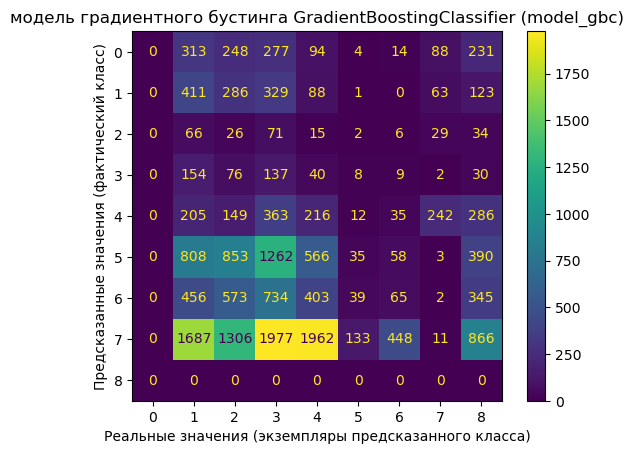

In [22]:
conf_matrix = confusion_matrix(data_test["target_gbc"], data_test["Product_Info_2_2"])
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.xlabel("Реальные значения (экземпляры предсказанного класса)") # для оси x
plt.ylabel("Предсказанные значения (фактический класс)") # для оси y
plt.title("модель градиентного бустинга GradientBoostingClassifier (model_gbc)") # заголовок
plt.show()

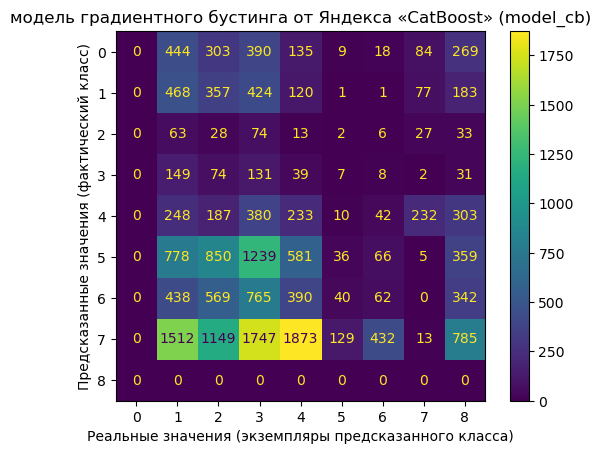

In [23]:
conf_matrix = confusion_matrix(data_test["target_cb"], data_test["Product_Info_2_2"])
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.xlabel("Реальные значения (экземпляры предсказанного класса)") # для оси x
plt.ylabel("Предсказанные значения (фактический класс)") # для оси y
plt.title("модель градиентного бустинга от Яндекса «CatBoost» (model_cb)") # заголовок
plt.show()

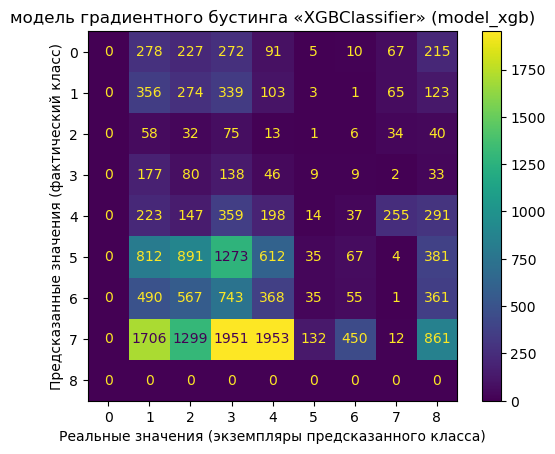

In [24]:
conf_matrix = confusion_matrix(data_test["target_xgb"], data_test["Product_Info_2_2"])
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.xlabel("Реальные значения (экземпляры предсказанного класса)") # для оси x
plt.ylabel("Предсказанные значения (фактический класс)") # для оси y
plt.title("модель градиентного бустинга «XGBClassifier» (model_xgb)") # заголовок
plt.show()

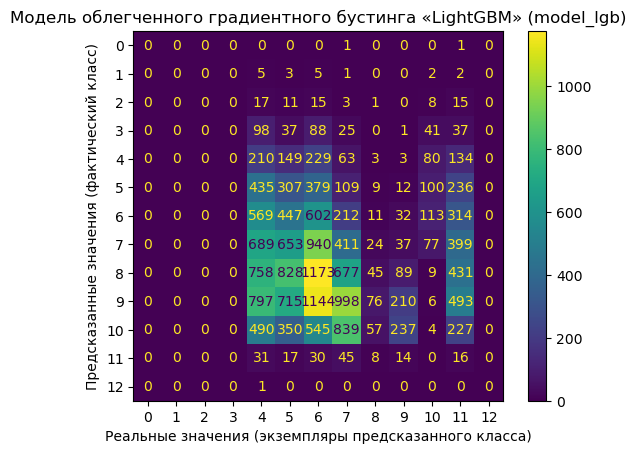

In [25]:
conf_matrix = confusion_matrix(data_test["target_lgb"], data_test["Product_Info_2_2"])
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.xlabel("Реальные значения (экземпляры предсказанного класса)") # для оси x
plt.ylabel("Предсказанные значения (фактический класс)") # для оси y
plt.title("Модель облегченного градиентного бустинга «LightGBM» (model_lgb)") # заголовок
plt.show()

Анализ рассчитанных матриц ошибок:
1) Для моделей «GradientBoostingClassifier», «CatBoost», «XGBClassifier»
классы смещены на 3 (начинаются от 0 и заканчиваются 7);
2) Для модели «LightGBM» классы смещены на 3 (начинаются от 4 и заканчиваются 11) 
Точнее работает для:
1 класса - модель градиентного бустинга «XGBClassifier»;
3 класса - модель градиентного бустинга GradientBoostingClassifier;
4 класса - модель градиентного бустинга GradientBoostingClassifier;
6 класса - модель облегченного градиентного бустинга «LightGBM».


Точные параметры классов можно перерассчитать, например, через перекрестную проверку всех данных.

In [26]:
# Вызовим функцию "vote_class" по параметру "x", уточним параметры классов для моделей
def vote_class (x):
    if x.target_xgb == 2:
        class_ = x.target_xgb
#    elif x.target_lgb == 7:
#        class_ = x.target_lgb
#    elif x.target_cb == 0:
#        class_ = x.target_cb
    else:
        class_ = x.target_gbc
    x["Response"] = class_ + 1
    return x #возвращаем значение "x"  

In [27]:
# преобразуем массив данных "data_test" по условиям функции "vote_class"
data_test = data_test.apply(vote_class, axis=1)
# просмотрим первые пять строк в Dataframe «data_test»
print (data_test.head())

     Id  Product_Info_1  Product_Info_3  Product_Info_4  Product_Info_5  \
0   1.0             1.0            26.0        0.487061             2.0   
1   3.0             1.0            26.0        0.076904             2.0   
2   4.0             1.0            26.0        0.144653             2.0   
3   9.0             1.0            26.0        0.151733             2.0   
4  12.0             1.0            26.0        0.076904             2.0   

   Product_Info_6  Product_Info_7   Ins_Age        Ht        Wt  ...  \
0             3.0             1.0  0.611816  0.781738  0.338867  ...   
1             3.0             1.0  0.626953  0.727051  0.311768  ...   
2             3.0             1.0  0.582031  0.708984  0.320068  ...   
3             1.0             1.0  0.522461  0.654785  0.267822  ...   
4             3.0             1.0  0.298584  0.672852  0.246826  ...   

   Product_Info_2_1D  Product_Info_2_1A  Product_Info_2_1E  Product_Info_2_1B  \
0                1.0               

### Формирование и выгрузка результатов
Загрузим примерный файл, заменим в нем результаты и сохраним.

Число строк в файле будет равно размену набора данных + 1 заголовочная строка.

In [28]:
submission = pd.read_csv("https://video.ittensive.com/machine-learning/prudential/sample_submission.csv.gz")
submission["Response"] = data_test["Response"].astype("int8")
submission.to_csv("submission.csv", index=False)
print (len(submission["Response"]) + 1)

19766


### Само-проверка модели
Рассчитаем точность классификации на обучающих данных

In [29]:
data_copy = data_transformed.copy()
x_copy = pd.DataFrame(data_copy, columns=columns_transformed)
copy_dataset = Pool(data=x_copy, label=data_copy["Response"])
data_copy["target_xgb"] = model_xgb.predict(x_copy)
data_copy["target_cb"] = model_cb.predict(copy_dataset)
data_copy["target_gbc"] = model_gbc.predict(x_copy)
data_copy["target_lgb"] = np.round(model_lgb.predict(x_copy)).astype("int8")

In [30]:
class_target = ["target_gbc"]*8
def vote_class_enumerate (x):
    for _,target in enumerate(class_target):
        if x[target] == _:
            x["Response"] = x[target]
            break
    return x

In [31]:
kappa_min = 0
for target_model in ["xgb", "cb", "gbc", "lgb"]:
    print ("Проверяем модель:", target_model)
    target_model = "target_" + target_model
    for class_ in range(0,8):
        target_model_prev = class_target[class_]
        class_target[class_] = target_model
        data_copy = data_copy.apply(vote_class_enumerate, axis=1)
        kappa = cohen_kappa_score(data_copy["Response"], 
                data["Response"], weights='quadratic')
        if kappa > kappa_min:
            kappa_min = kappa
        else:
            class_target[class_] = target_model_prev
    print ("Максимальная оценка:", kappa_min)
print (class_target)

Проверяем модель: xgb
Максимальная оценка: 0.91923523748714
Проверяем модель: cb
Максимальная оценка: 0.923490383367688
Проверяем модель: gbc
Максимальная оценка: 0.9235305740712393
Проверяем модель: lgb
Максимальная оценка: 0.9239003098498227
['target_cb', 'target_cb', 'target_xgb', 'target_xgb', 'target_gbc', 'target_cb', 'target_lgb', 'target_xgb']


In [32]:
data_copy = data_copy.apply(vote_class_enumerate, axis=1)

In [33]:
print ("Результат:",
       round(cohen_kappa_score(data_copy["Response"],
                    data["Response"], weights='quadratic'), 3))
print (confusion_matrix(data_copy["Response"], data["Response"]))

Результат: 0.924
[[    0     0     0     0     0     0     0     0     0]
 [ 6207     0     0     0     0     0     0     0     0]
 [    0  6552     0     0     0     0     0     0     0]
 [    0     0  1013     0     0     0     0     0     0]
 [    0     0     0  1428     6     0     0     0     0]
 [    0     0     0     0  5308    89    18    10     0]
 [    0     0     0     0   117 11143   202     0     0]
 [    0     0     0     0     1     0  7788   863     0]
 [    0     0     0     0     0     1    19 18616     0]]


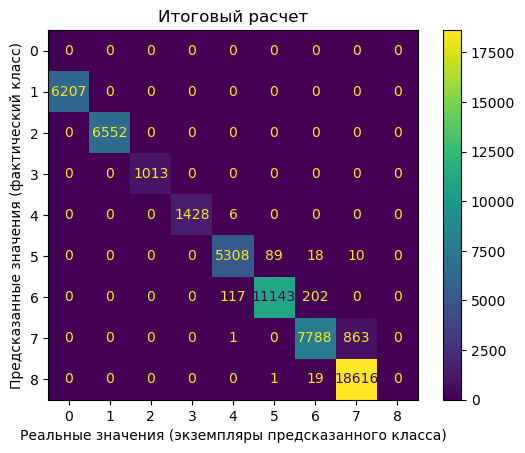

In [34]:
conf_matrix = confusion_matrix(data_copy["Response"], data["Response"])
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.xlabel("Реальные значения (экземпляры предсказанного класса)") # для оси x
plt.ylabel("Предсказанные значения (фактический класс)") # для оси y
plt.title("Итоговый расчет") # заголовок
plt.show()